# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in
TensorFlow.  For example, suppose we are building a biological reinforcement learning
model, but we'd like the inputs to our model to be natural images rather than artificial
vectors.  We could load a vision network from TensorFlow, insert it into our model using
NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the
[TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to
write code directly in TensorFlow, and then insert it easily into Nengo.  In this
example we will demonstrate how to integrate a Keras network into a Nengo model in a
series of stages. First, inserting an entire Keras model, second, inserting individual
Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the
node to insert Python code into our model we will use it to insert TensorFlow code.

The first thing we need to do is define our TensorNode output.  This is a function that
accepts the current simulation time (and, optionally, a batch of vectors) as input, and
produces a batch of vectors as output.  All of these variables will be represented as
`tf.Tensor` objects, and the internal operations of the TensorNode will be implemented
with TensorFlow operations. For example, we could use a TensorNode to output a `sin`
function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

|      #                      Simulating                              | 0:00:00

|       #                     Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

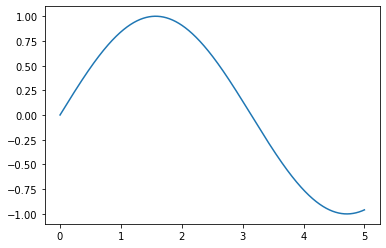

In [2]:
with nengo.Network() as net:

    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)

        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))

        return output

    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)

plt.figure()
plt.plot(sim.trange(), sim.data[p])
plt.show()

However, outputting a `sin` function is something we could do more easily with a regular
`nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more
complex TensorFlow code and insert it into a NengoDL model. For example, one thing we
often want to do is take a deep network written in TensorFlow/Keras, and add it into a
Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software
package for building and training deep learning style networks.  It is a higher-level
API within TensorFlow to make it easier to construct and train deep networks.  And
because it is all implemented as a TensorFlow network under the hood, we can define a
network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the
[introduction in the Tensorflow
documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are
not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.
This dataset contains images of clothing, and the goal of the network is to identify
what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

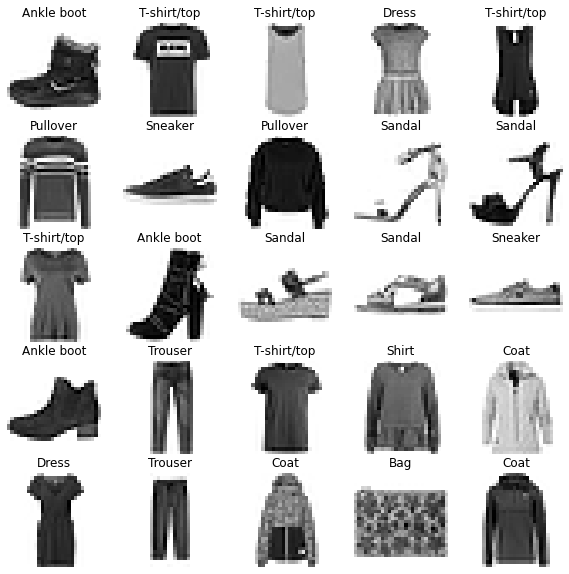

In [3]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're
building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in
NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do
everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 20:22 - loss: 2.2751 - accuracy: 0.0938

  30/1875 [..............................] - ETA: 3s - loss: 1.3429 - accuracy: 0.5344   

  59/1875 [..............................] - ETA: 3s - loss: 1.1091 - accuracy: 0.6123

  87/1875 [>.............................] - ETA: 3s - loss: 0.9706 - accuracy: 0.6609

 117/1875 [>.............................] - ETA: 3s - loss: 0.8846 - accuracy: 0.6891

 146/1875 [=>............................] - ETA: 3s - loss: 0.8353 - accuracy: 0.7059

 175/1875 [=>............................] - ETA: 2s - loss: 0.7961 - accuracy: 0.7200

 205/1875 [==>...........................] - ETA: 2s - loss: 0.7732 - accuracy: 0.7274

 235/1875 [==>...........................] - ETA: 2s - loss: 0.7462 - accuracy: 0.7394

 265/1875 [===>..........................] - ETA: 2s - loss: 0.7229 - accuracy: 0.7476

 295/1875 [===>..........................] - ETA: 2s - loss: 0.7028 - accuracy: 0.7534

 324/1875 [====>.........................] - ETA: 2s - loss: 0.6930 - accuracy: 0.7559

 354/1875 [====>.........................] - ETA: 2s - loss: 0.6790 - accuracy: 0.7605

 383/1875 [=====>........................] - ETA: 2s - loss: 0.6709 - accuracy: 0.7634

 412/1875 [=====>........................] - ETA: 2s - loss: 0.6600 - accuracy: 0.7684

 442/1875 [======>.......................] - ETA: 2s - loss: 0.6518 - accuracy: 0.7716

 472/1875 [======>.......................] - ETA: 2s - loss: 0.6422 - accuracy: 0.7755

 502/1875 [=======>......................] - ETA: 2s - loss: 0.6365 - accuracy: 0.7772

 532/1875 [=======>......................] - ETA: 2s - loss: 0.6282 - accuracy: 0.7801

 562/1875 [=======>......................] - ETA: 2s - loss: 0.6213 - accuracy: 0.7827

 592/1875 [========>.....................] - ETA: 2s - loss: 0.6174 - accuracy: 0.7836

 622/1875 [========>.....................] - ETA: 2s - loss: 0.6118 - accuracy: 0.7857

 651/1875 [=========>....................] - ETA: 2s - loss: 0.6061 - accuracy: 0.7884

 681/1875 [=========>....................] - ETA: 2s - loss: 0.5995 - accuracy: 0.7909

 709/1875 [==========>...................] - ETA: 2s - loss: 0.5950 - accuracy: 0.7926

 739/1875 [==========>...................] - ETA: 1s - loss: 0.5898 - accuracy: 0.7939

 768/1875 [===========>..................] - ETA: 1s - loss: 0.5856 - accuracy: 0.7946

 798/1875 [===========>..................] - ETA: 1s - loss: 0.5814 - accuracy: 0.7954

 828/1875 [============>.................] - ETA: 1s - loss: 0.5789 - accuracy: 0.7959

 858/1875 [============>.................] - ETA: 1s - loss: 0.5760 - accuracy: 0.7969

 888/1875 [=============>................] - ETA: 1s - loss: 0.5722 - accuracy: 0.7986

 918/1875 [=============>................] - ETA: 1s - loss: 0.5661 - accuracy: 0.8010

 947/1875 [==============>...............] - ETA: 1s - loss: 0.5629 - accuracy: 0.8022

 976/1875 [==============>...............] - ETA: 1s - loss: 0.5602 - accuracy: 0.8033

1006/1875 [===============>..............] - ETA: 1s - loss: 0.5572 - accuracy: 0.8044

1036/1875 [===============>..............] - ETA: 1s - loss: 0.5529 - accuracy: 0.8057

1067/1875 [================>.............] - ETA: 1s - loss: 0.5504 - accuracy: 0.8066

1097/1875 [================>.............] - ETA: 1s - loss: 0.5475 - accuracy: 0.8077

1127/1875 [=================>............] - ETA: 1s - loss: 0.5446 - accuracy: 0.8090

1157/1875 [=================>............] - ETA: 1s - loss: 0.5422 - accuracy: 0.8095

1188/1875 [==================>...........] - ETA: 1s - loss: 0.5387 - accuracy: 0.8106

1218/1875 [==================>...........] - ETA: 1s - loss: 0.5364 - accuracy: 0.8113

1248/1875 [==================>...........] - ETA: 1s - loss: 0.5338 - accuracy: 0.8124

1278/1875 [===================>..........] - ETA: 1s - loss: 0.5317 - accuracy: 0.8132

1308/1875 [===================>..........] - ETA: 0s - loss: 0.5304 - accuracy: 0.8136

1338/1875 [====================>.........] - ETA: 0s - loss: 0.5286 - accuracy: 0.8144

1368/1875 [====================>.........] - ETA: 0s - loss: 0.5263 - accuracy: 0.8151

1397/1875 [=====================>........] - ETA: 0s - loss: 0.5243 - accuracy: 0.8158

1427/1875 [=====================>........] - ETA: 0s - loss: 0.5216 - accuracy: 0.8166

1458/1875 [======================>.......] - ETA: 0s - loss: 0.5195 - accuracy: 0.8175

1488/1875 [======================>.......] - ETA: 0s - loss: 0.5170 - accuracy: 0.8183

1518/1875 [=======================>......] - ETA: 0s - loss: 0.5153 - accuracy: 0.8191

1548/1875 [=======================>......] - ETA: 0s - loss: 0.5146 - accuracy: 0.8191

1579/1875 [========================>.....] - ETA: 0s - loss: 0.5134 - accuracy: 0.8195

1609/1875 [========================>.....] - ETA: 0s - loss: 0.5122 - accuracy: 0.8199

1639/1875 [=========================>....] - ETA: 0s - loss: 0.5101 - accuracy: 0.8206

1668/1875 [=========================>....] - ETA: 0s - loss: 0.5082 - accuracy: 0.8213

1695/1875 [==========================>...] - ETA: 0s - loss: 0.5077 - accuracy: 0.8216

1722/1875 [==========================>...] - ETA: 0s - loss: 0.5068 - accuracy: 0.8218

1750/1875 [===========================>..] - ETA: 0s - loss: 0.5041 - accuracy: 0.8227

1780/1875 [===========================>..] - ETA: 0s - loss: 0.5022 - accuracy: 0.8234

1810/1875 [===========================>..] - ETA: 0s - loss: 0.5013 - accuracy: 0.8237

1839/1875 [============================>.] - ETA: 0s - loss: 0.5005 - accuracy: 0.8243

1867/1875 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8242

1875/1875 [==============================] - 4s 2ms/step - loss: 0.4997 - accuracy: 0.8242


Epoch 2/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1640 - accuracy: 0.9375

  32/1875 [..............................] - ETA: 3s - loss: 0.3761 - accuracy: 0.8711

  62/1875 [..............................] - ETA: 3s - loss: 0.3723 - accuracy: 0.8745

  93/1875 [>.............................] - ETA: 2s - loss: 0.3890 - accuracy: 0.8656

 123/1875 [>.............................] - ETA: 2s - loss: 0.3945 - accuracy: 0.8633

 154/1875 [=>............................] - ETA: 2s - loss: 0.3966 - accuracy: 0.8588

 184/1875 [=>............................] - ETA: 2s - loss: 0.3995 - accuracy: 0.8582

 215/1875 [==>...........................] - ETA: 2s - loss: 0.3925 - accuracy: 0.8596

 246/1875 [==>...........................] - ETA: 2s - loss: 0.3906 - accuracy: 0.8600

 276/1875 [===>..........................] - ETA: 2s - loss: 0.3938 - accuracy: 0.8576

 306/1875 [===>..........................] - ETA: 2s - loss: 0.3990 - accuracy: 0.8561

 335/1875 [====>.........................] - ETA: 2s - loss: 0.3957 - accuracy: 0.8571

 365/1875 [====>.........................] - ETA: 2s - loss: 0.3916 - accuracy: 0.8590

 395/1875 [=====>........................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8585

 424/1875 [=====>........................] - ETA: 2s - loss: 0.3886 - accuracy: 0.8589

 454/1875 [======>.......................] - ETA: 2s - loss: 0.3874 - accuracy: 0.8590

 484/1875 [======>.......................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8597

 513/1875 [=======>......................] - ETA: 2s - loss: 0.3880 - accuracy: 0.8590

 543/1875 [=======>......................] - ETA: 2s - loss: 0.3853 - accuracy: 0.8606

 573/1875 [========>.....................] - ETA: 2s - loss: 0.3864 - accuracy: 0.8596

 603/1875 [========>.....................] - ETA: 2s - loss: 0.3873 - accuracy: 0.8591

 633/1875 [=========>....................] - ETA: 2s - loss: 0.3857 - accuracy: 0.8597

 664/1875 [=========>....................] - ETA: 2s - loss: 0.3877 - accuracy: 0.8588

 694/1875 [==========>...................] - ETA: 1s - loss: 0.3856 - accuracy: 0.8594

 724/1875 [==========>...................] - ETA: 1s - loss: 0.3871 - accuracy: 0.8587

 754/1875 [===========>..................] - ETA: 1s - loss: 0.3873 - accuracy: 0.8591

 784/1875 [===========>..................] - ETA: 1s - loss: 0.3872 - accuracy: 0.8595

 814/1875 [============>.................] - ETA: 1s - loss: 0.3883 - accuracy: 0.8589

 844/1875 [============>.................] - ETA: 1s - loss: 0.3864 - accuracy: 0.8597

 874/1875 [============>.................] - ETA: 1s - loss: 0.3841 - accuracy: 0.8609

 904/1875 [=============>................] - ETA: 1s - loss: 0.3847 - accuracy: 0.8609

 934/1875 [=============>................] - ETA: 1s - loss: 0.3841 - accuracy: 0.8610

 964/1875 [==============>...............] - ETA: 1s - loss: 0.3829 - accuracy: 0.8612

 995/1875 [==============>...............] - ETA: 1s - loss: 0.3823 - accuracy: 0.8614

1023/1875 [===============>..............] - ETA: 1s - loss: 0.3828 - accuracy: 0.8609

1052/1875 [===============>..............] - ETA: 1s - loss: 0.3825 - accuracy: 0.8611

1082/1875 [================>.............] - ETA: 1s - loss: 0.3810 - accuracy: 0.8616

1112/1875 [================>.............] - ETA: 1s - loss: 0.3798 - accuracy: 0.8623

1142/1875 [=================>............] - ETA: 1s - loss: 0.3788 - accuracy: 0.8625

1172/1875 [=================>............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8625

1203/1875 [==================>...........] - ETA: 1s - loss: 0.3797 - accuracy: 0.8627

1233/1875 [==================>...........] - ETA: 1s - loss: 0.3803 - accuracy: 0.8624

1263/1875 [===================>..........] - ETA: 1s - loss: 0.3806 - accuracy: 0.8622

1291/1875 [===================>..........] - ETA: 0s - loss: 0.3812 - accuracy: 0.8614

1321/1875 [====================>.........] - ETA: 0s - loss: 0.3820 - accuracy: 0.8610

1350/1875 [====================>.........] - ETA: 0s - loss: 0.3818 - accuracy: 0.8610

1380/1875 [=====================>........] - ETA: 0s - loss: 0.3812 - accuracy: 0.8612

1409/1875 [=====================>........] - ETA: 0s - loss: 0.3796 - accuracy: 0.8618

1437/1875 [=====================>........] - ETA: 0s - loss: 0.3804 - accuracy: 0.8615

1467/1875 [======================>.......] - ETA: 0s - loss: 0.3801 - accuracy: 0.8619

1496/1875 [======================>.......] - ETA: 0s - loss: 0.3801 - accuracy: 0.8618

1526/1875 [=======================>......] - ETA: 0s - loss: 0.3798 - accuracy: 0.8620

1556/1875 [=======================>......] - ETA: 0s - loss: 0.3802 - accuracy: 0.8619

1586/1875 [========================>.....] - ETA: 0s - loss: 0.3809 - accuracy: 0.8618

1615/1875 [========================>.....] - ETA: 0s - loss: 0.3801 - accuracy: 0.8622

1645/1875 [=========================>....] - ETA: 0s - loss: 0.3791 - accuracy: 0.8625

1675/1875 [=========================>....] - ETA: 0s - loss: 0.3788 - accuracy: 0.8627

1706/1875 [==========================>...] - ETA: 0s - loss: 0.3794 - accuracy: 0.8626

1735/1875 [==========================>...] - ETA: 0s - loss: 0.3789 - accuracy: 0.8625

1761/1875 [===========================>..] - ETA: 0s - loss: 0.3783 - accuracy: 0.8628

1792/1875 [===========================>..] - ETA: 0s - loss: 0.3775 - accuracy: 0.8631

1822/1875 [============================>.] - ETA: 0s - loss: 0.3777 - accuracy: 0.8630

1853/1875 [============================>.] - ETA: 0s - loss: 0.3765 - accuracy: 0.8637

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3763 - accuracy: 0.8638


Epoch 3/5


   1/1875 [..............................] - ETA: 4s - loss: 0.4660 - accuracy: 0.8750

  31/1875 [..............................] - ETA: 3s - loss: 0.3360 - accuracy: 0.8760

  61/1875 [..............................] - ETA: 3s - loss: 0.3618 - accuracy: 0.8678

  90/1875 [>.............................] - ETA: 3s - loss: 0.3562 - accuracy: 0.8705

 120/1875 [>.............................] - ETA: 2s - loss: 0.3582 - accuracy: 0.8674

 149/1875 [=>............................] - ETA: 2s - loss: 0.3520 - accuracy: 0.8693

 177/1875 [=>............................] - ETA: 2s - loss: 0.3442 - accuracy: 0.8725

 207/1875 [==>...........................] - ETA: 2s - loss: 0.3420 - accuracy: 0.8736

 237/1875 [==>...........................] - ETA: 2s - loss: 0.3352 - accuracy: 0.8757

 267/1875 [===>..........................] - ETA: 2s - loss: 0.3380 - accuracy: 0.8758

 297/1875 [===>..........................] - ETA: 2s - loss: 0.3387 - accuracy: 0.8756

 327/1875 [====>.........................] - ETA: 2s - loss: 0.3363 - accuracy: 0.8763

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3362 - accuracy: 0.8770

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3353 - accuracy: 0.8776

 416/1875 [=====>........................] - ETA: 2s - loss: 0.3375 - accuracy: 0.8758

 446/1875 [======>.......................] - ETA: 2s - loss: 0.3355 - accuracy: 0.8761

 476/1875 [======>.......................] - ETA: 2s - loss: 0.3373 - accuracy: 0.8757

 506/1875 [=======>......................] - ETA: 2s - loss: 0.3386 - accuracy: 0.8747

 536/1875 [=======>......................] - ETA: 2s - loss: 0.3402 - accuracy: 0.8751

 566/1875 [========>.....................] - ETA: 2s - loss: 0.3394 - accuracy: 0.8758

 596/1875 [========>.....................] - ETA: 2s - loss: 0.3389 - accuracy: 0.8756

 626/1875 [=========>....................] - ETA: 2s - loss: 0.3393 - accuracy: 0.8752

 656/1875 [=========>....................] - ETA: 2s - loss: 0.3403 - accuracy: 0.8748

 686/1875 [=========>....................] - ETA: 2s - loss: 0.3409 - accuracy: 0.8743

 716/1875 [==========>...................] - ETA: 1s - loss: 0.3414 - accuracy: 0.8739

 745/1875 [==========>...................] - ETA: 1s - loss: 0.3415 - accuracy: 0.8737

 775/1875 [===========>..................] - ETA: 1s - loss: 0.3428 - accuracy: 0.8731

 805/1875 [===========>..................] - ETA: 1s - loss: 0.3428 - accuracy: 0.8731

 836/1875 [============>.................] - ETA: 1s - loss: 0.3425 - accuracy: 0.8730

 865/1875 [============>.................] - ETA: 1s - loss: 0.3417 - accuracy: 0.8735

 895/1875 [=============>................] - ETA: 1s - loss: 0.3409 - accuracy: 0.8740

 924/1875 [=============>................] - ETA: 1s - loss: 0.3392 - accuracy: 0.8749

 954/1875 [==============>...............] - ETA: 1s - loss: 0.3385 - accuracy: 0.8752

 984/1875 [==============>...............] - ETA: 1s - loss: 0.3391 - accuracy: 0.8749

1014/1875 [===============>..............] - ETA: 1s - loss: 0.3387 - accuracy: 0.8751

1044/1875 [===============>..............] - ETA: 1s - loss: 0.3391 - accuracy: 0.8752

1072/1875 [================>.............] - ETA: 1s - loss: 0.3383 - accuracy: 0.8754

1100/1875 [================>.............] - ETA: 1s - loss: 0.3385 - accuracy: 0.8754

1130/1875 [=================>............] - ETA: 1s - loss: 0.3379 - accuracy: 0.8758

1157/1875 [=================>............] - ETA: 1s - loss: 0.3380 - accuracy: 0.8758

1184/1875 [=================>............] - ETA: 1s - loss: 0.3383 - accuracy: 0.8758

1213/1875 [==================>...........] - ETA: 1s - loss: 0.3374 - accuracy: 0.8762

1242/1875 [==================>...........] - ETA: 1s - loss: 0.3365 - accuracy: 0.8767

1272/1875 [===================>..........] - ETA: 1s - loss: 0.3366 - accuracy: 0.8764

1297/1875 [===================>..........] - ETA: 0s - loss: 0.3360 - accuracy: 0.8765

1326/1875 [====================>.........] - ETA: 0s - loss: 0.3349 - accuracy: 0.8771

1355/1875 [====================>.........] - ETA: 0s - loss: 0.3365 - accuracy: 0.8767

1385/1875 [=====================>........] - ETA: 0s - loss: 0.3367 - accuracy: 0.8767

1415/1875 [=====================>........] - ETA: 0s - loss: 0.3370 - accuracy: 0.8766

1445/1875 [======================>.......] - ETA: 0s - loss: 0.3366 - accuracy: 0.8768

1474/1875 [======================>.......] - ETA: 0s - loss: 0.3367 - accuracy: 0.8767

1504/1875 [=======================>......] - ETA: 0s - loss: 0.3367 - accuracy: 0.8769

1534/1875 [=======================>......] - ETA: 0s - loss: 0.3377 - accuracy: 0.8766

1563/1875 [========================>.....] - ETA: 0s - loss: 0.3376 - accuracy: 0.8766

1593/1875 [========================>.....] - ETA: 0s - loss: 0.3382 - accuracy: 0.8765

1621/1875 [========================>.....] - ETA: 0s - loss: 0.3379 - accuracy: 0.8764

1651/1875 [=========================>....] - ETA: 0s - loss: 0.3384 - accuracy: 0.8762

1679/1875 [=========================>....] - ETA: 0s - loss: 0.3378 - accuracy: 0.8764

1708/1875 [==========================>...] - ETA: 0s - loss: 0.3377 - accuracy: 0.8761

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3385 - accuracy: 0.8758

1764/1875 [===========================>..] - ETA: 0s - loss: 0.3377 - accuracy: 0.8760

1794/1875 [===========================>..] - ETA: 0s - loss: 0.3369 - accuracy: 0.8764

1823/1875 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8763

1853/1875 [============================>.] - ETA: 0s - loss: 0.3371 - accuracy: 0.8762

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3372 - accuracy: 0.8763


Epoch 4/5


   1/1875 [..............................] - ETA: 5s - loss: 0.1792 - accuracy: 0.9688

  31/1875 [..............................] - ETA: 3s - loss: 0.3314 - accuracy: 0.8629

  61/1875 [..............................] - ETA: 3s - loss: 0.3451 - accuracy: 0.8642

  91/1875 [>.............................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8695

 121/1875 [>.............................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8763

 151/1875 [=>............................] - ETA: 2s - loss: 0.3128 - accuracy: 0.8796

 179/1875 [=>............................] - ETA: 2s - loss: 0.3189 - accuracy: 0.8780

 209/1875 [==>...........................] - ETA: 2s - loss: 0.3183 - accuracy: 0.8786

 239/1875 [==>...........................] - ETA: 2s - loss: 0.3124 - accuracy: 0.8798

 269/1875 [===>..........................] - ETA: 2s - loss: 0.3122 - accuracy: 0.8813

 297/1875 [===>..........................] - ETA: 2s - loss: 0.3153 - accuracy: 0.8813

 327/1875 [====>.........................] - ETA: 2s - loss: 0.3131 - accuracy: 0.8824

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3152 - accuracy: 0.8820

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3159 - accuracy: 0.8815

 416/1875 [=====>........................] - ETA: 2s - loss: 0.3161 - accuracy: 0.8819

 446/1875 [======>.......................] - ETA: 2s - loss: 0.3127 - accuracy: 0.8832

 476/1875 [======>.......................] - ETA: 2s - loss: 0.3139 - accuracy: 0.8833

 506/1875 [=======>......................] - ETA: 2s - loss: 0.3126 - accuracy: 0.8835

 536/1875 [=======>......................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8850

 566/1875 [========>.....................] - ETA: 2s - loss: 0.3095 - accuracy: 0.8853

 596/1875 [========>.....................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8851

 626/1875 [=========>....................] - ETA: 2s - loss: 0.3111 - accuracy: 0.8850

 657/1875 [=========>....................] - ETA: 2s - loss: 0.3122 - accuracy: 0.8847

 687/1875 [=========>....................] - ETA: 2s - loss: 0.3130 - accuracy: 0.8839

 717/1875 [==========>...................] - ETA: 1s - loss: 0.3115 - accuracy: 0.8847

 747/1875 [==========>...................] - ETA: 1s - loss: 0.3111 - accuracy: 0.8850

 777/1875 [===========>..................] - ETA: 1s - loss: 0.3107 - accuracy: 0.8851

 806/1875 [===========>..................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8856

 836/1875 [============>.................] - ETA: 1s - loss: 0.3078 - accuracy: 0.8867

 866/1875 [============>.................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8858

 895/1875 [=============>................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8864

 923/1875 [=============>................] - ETA: 1s - loss: 0.3087 - accuracy: 0.8862

 953/1875 [==============>...............] - ETA: 1s - loss: 0.3091 - accuracy: 0.8859

 983/1875 [==============>...............] - ETA: 1s - loss: 0.3089 - accuracy: 0.8860

1013/1875 [===============>..............] - ETA: 1s - loss: 0.3093 - accuracy: 0.8861

1042/1875 [===============>..............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8860

1070/1875 [================>.............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8855

1098/1875 [================>.............] - ETA: 1s - loss: 0.3106 - accuracy: 0.8858

1127/1875 [=================>............] - ETA: 1s - loss: 0.3101 - accuracy: 0.8860

1152/1875 [=================>............] - ETA: 1s - loss: 0.3105 - accuracy: 0.8859

1181/1875 [=================>............] - ETA: 1s - loss: 0.3104 - accuracy: 0.8860

1206/1875 [==================>...........] - ETA: 1s - loss: 0.3097 - accuracy: 0.8862

1236/1875 [==================>...........] - ETA: 1s - loss: 0.3100 - accuracy: 0.8860

1264/1875 [===================>..........] - ETA: 1s - loss: 0.3099 - accuracy: 0.8859

1294/1875 [===================>..........] - ETA: 1s - loss: 0.3096 - accuracy: 0.8859

1324/1875 [====================>.........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8861

1354/1875 [====================>.........] - ETA: 0s - loss: 0.3090 - accuracy: 0.8864

1384/1875 [=====================>........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8865

1413/1875 [=====================>........] - ETA: 0s - loss: 0.3088 - accuracy: 0.8869

1435/1875 [=====================>........] - ETA: 0s - loss: 0.3094 - accuracy: 0.8867

1464/1875 [======================>.......] - ETA: 0s - loss: 0.3094 - accuracy: 0.8863

1493/1875 [======================>.......] - ETA: 0s - loss: 0.3094 - accuracy: 0.8863

1522/1875 [=======================>......] - ETA: 0s - loss: 0.3093 - accuracy: 0.8862

1547/1875 [=======================>......] - ETA: 0s - loss: 0.3093 - accuracy: 0.8860

1569/1875 [========================>.....] - ETA: 0s - loss: 0.3092 - accuracy: 0.8861

1594/1875 [========================>.....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8862

1623/1875 [========================>.....] - ETA: 0s - loss: 0.3098 - accuracy: 0.8858

1652/1875 [=========================>....] - ETA: 0s - loss: 0.3095 - accuracy: 0.8860

1681/1875 [=========================>....] - ETA: 0s - loss: 0.3089 - accuracy: 0.8861

1710/1875 [==========================>...] - ETA: 0s - loss: 0.3087 - accuracy: 0.8864

1740/1875 [==========================>...] - ETA: 0s - loss: 0.3083 - accuracy: 0.8867

1770/1875 [===========================>..] - ETA: 0s - loss: 0.3086 - accuracy: 0.8866

1800/1875 [===========================>..] - ETA: 0s - loss: 0.3098 - accuracy: 0.8860

1831/1875 [============================>.] - ETA: 0s - loss: 0.3111 - accuracy: 0.8857

1860/1875 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8854

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3109 - accuracy: 0.8854


Epoch 5/5


   1/1875 [..............................] - ETA: 4s - loss: 0.1864 - accuracy: 0.9375

  32/1875 [..............................] - ETA: 3s - loss: 0.3164 - accuracy: 0.8779

  62/1875 [..............................] - ETA: 3s - loss: 0.2832 - accuracy: 0.8831

  92/1875 [>.............................] - ETA: 2s - loss: 0.2672 - accuracy: 0.8920

 122/1875 [>.............................] - ETA: 2s - loss: 0.2665 - accuracy: 0.8940

 152/1875 [=>............................] - ETA: 2s - loss: 0.2741 - accuracy: 0.8919

 182/1875 [=>............................] - ETA: 2s - loss: 0.2779 - accuracy: 0.8941

 212/1875 [==>...........................] - ETA: 2s - loss: 0.2832 - accuracy: 0.8925

 242/1875 [==>...........................] - ETA: 2s - loss: 0.2863 - accuracy: 0.8919

 271/1875 [===>..........................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8910

 301/1875 [===>..........................] - ETA: 2s - loss: 0.2876 - accuracy: 0.8916

 331/1875 [====>.........................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8912

 361/1875 [====>.........................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8919

 391/1875 [=====>........................] - ETA: 2s - loss: 0.2874 - accuracy: 0.8935

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2869 - accuracy: 0.8937

 451/1875 [======>.......................] - ETA: 2s - loss: 0.2872 - accuracy: 0.8934

 481/1875 [======>.......................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8931

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2854 - accuracy: 0.8940

 541/1875 [=======>......................] - ETA: 2s - loss: 0.2892 - accuracy: 0.8931

 571/1875 [========>.....................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8929

 600/1875 [========>.....................] - ETA: 2s - loss: 0.2908 - accuracy: 0.8930

 630/1875 [=========>....................] - ETA: 2s - loss: 0.2933 - accuracy: 0.8924

 660/1875 [=========>....................] - ETA: 2s - loss: 0.2943 - accuracy: 0.8914

 687/1875 [=========>....................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8918

 717/1875 [==========>...................] - ETA: 1s - loss: 0.2928 - accuracy: 0.8920

 747/1875 [==========>...................] - ETA: 1s - loss: 0.2938 - accuracy: 0.8916

 777/1875 [===========>..................] - ETA: 1s - loss: 0.2946 - accuracy: 0.8912

 807/1875 [===========>..................] - ETA: 1s - loss: 0.2937 - accuracy: 0.8915

 837/1875 [============>.................] - ETA: 1s - loss: 0.2925 - accuracy: 0.8921

 866/1875 [============>.................] - ETA: 1s - loss: 0.2938 - accuracy: 0.8915

 896/1875 [=============>................] - ETA: 1s - loss: 0.2940 - accuracy: 0.8914

 926/1875 [=============>................] - ETA: 1s - loss: 0.2949 - accuracy: 0.8909

 955/1875 [==============>...............] - ETA: 1s - loss: 0.2952 - accuracy: 0.8909

 984/1875 [==============>...............] - ETA: 1s - loss: 0.2951 - accuracy: 0.8909

1013/1875 [===============>..............] - ETA: 1s - loss: 0.2945 - accuracy: 0.8909

1043/1875 [===============>..............] - ETA: 1s - loss: 0.2933 - accuracy: 0.8913

1073/1875 [================>.............] - ETA: 1s - loss: 0.2922 - accuracy: 0.8914

1104/1875 [================>.............] - ETA: 1s - loss: 0.2915 - accuracy: 0.8917

1134/1875 [=================>............] - ETA: 1s - loss: 0.2916 - accuracy: 0.8918

1161/1875 [=================>............] - ETA: 1s - loss: 0.2913 - accuracy: 0.8917

1189/1875 [==================>...........] - ETA: 1s - loss: 0.2903 - accuracy: 0.8923

1219/1875 [==================>...........] - ETA: 1s - loss: 0.2913 - accuracy: 0.8921

1249/1875 [==================>...........] - ETA: 1s - loss: 0.2920 - accuracy: 0.8918

1278/1875 [===================>..........] - ETA: 1s - loss: 0.2919 - accuracy: 0.8918

1308/1875 [===================>..........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8920

1338/1875 [====================>.........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8919

1367/1875 [====================>.........] - ETA: 0s - loss: 0.2915 - accuracy: 0.8920

1392/1875 [=====================>........] - ETA: 0s - loss: 0.2918 - accuracy: 0.8918

1422/1875 [=====================>........] - ETA: 0s - loss: 0.2928 - accuracy: 0.8914

1451/1875 [======================>.......] - ETA: 0s - loss: 0.2937 - accuracy: 0.8912

1480/1875 [======================>.......] - ETA: 0s - loss: 0.2940 - accuracy: 0.8909

1505/1875 [=======================>......] - ETA: 0s - loss: 0.2948 - accuracy: 0.8906

1535/1875 [=======================>......] - ETA: 0s - loss: 0.2948 - accuracy: 0.8905

1564/1875 [========================>.....] - ETA: 0s - loss: 0.2939 - accuracy: 0.8909

1593/1875 [========================>.....] - ETA: 0s - loss: 0.2939 - accuracy: 0.8910

1623/1875 [========================>.....] - ETA: 0s - loss: 0.2937 - accuracy: 0.8910

1652/1875 [=========================>....] - ETA: 0s - loss: 0.2936 - accuracy: 0.8912

1683/1875 [=========================>....] - ETA: 0s - loss: 0.2935 - accuracy: 0.8912

1713/1875 [==========================>...] - ETA: 0s - loss: 0.2937 - accuracy: 0.8912

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2938 - accuracy: 0.8911

1773/1875 [===========================>..] - ETA: 0s - loss: 0.2936 - accuracy: 0.8910

1803/1875 [===========================>..] - ETA: 0s - loss: 0.2934 - accuracy: 0.8912

1833/1875 [============================>.] - ETA: 0s - loss: 0.2933 - accuracy: 0.8912

1862/1875 [============================>.] - ETA: 0s - loss: 0.2936 - accuracy: 0.8910

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2936 - accuracy: 0.8910


Test accuracy: 0.8686000108718872


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more
complicated in this case, since we need to load in the model from above and the
pretrained weights.  We can accomplish this by creating a custom Keras Layer, which
allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This
effectively reruns the Keras model definition from above, but because we're calling it
within the `build` stage it will be naturally integrated into the NengoDL model that is
being built.

The `call` function is where we do the main job of constructing the TensorFlow elements
that will implement our node.  It will take TensorFlow Tensors as input and produce a
`tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the
Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement
that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()

        self.model = keras_model

    def build(self, input_shapes):
        super().build(input_shapes)

        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)

        # load the weights we saved above
        self.model.load_weights(model_weights)

    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into
a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in
our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)

    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28 * 28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and
connect them up to the Keras node (for example, if we wanted to take the classified
image labels and use them as input to a spiking neural model).  But to keep things
simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully
loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
with net:
    # we'll disable some features we don't need in this example, to improve
    # the training speed
    nengo_dl.configure_settings(stateful=False, use_loop=False)

minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8686000108718872


We can see that we're getting the same performance in Nengo as we were in Keras,
indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to
integrate a Keras model into Nengo by inserting the individual layers.  This requires
more manual translation work, but it makes it easier to make changes to the model later
on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this
time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to
the TensorNode.  However, we can make this construction process even simpler by using
`nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the
Keras functional layer API. Under the hood it's doing the same thing (creating
TensorNodes and Connections), but it allows us to define the model in a way that looks
very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
        inp
    )
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL
this time. Fortunately, the API is essentially the same:

In [11]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 20:18 - loss: 2.2471 - probe_loss: 2.2471 - probe_accuracy: 0.1000

  27/3000 [..............................] - ETA: 5s - loss: 1.4046 - probe_loss: 1.4046 - probe_accuracy: 0.4926   

  53/3000 [..............................] - ETA: 5s - loss: 1.1544 - probe_loss: 1.1544 - probe_accuracy: 0.5849

  78/3000 [..............................] - ETA: 5s - loss: 1.0455 - probe_loss: 1.0455 - probe_accuracy: 0.6288

 105/3000 [>.............................] - ETA: 5s - loss: 0.9800 - probe_loss: 0.9800 - probe_accuracy: 0.6571

 131/3000 [>.............................] - ETA: 5s - loss: 0.9112 - probe_loss: 0.9112 - probe_accuracy: 0.6775

 157/3000 [>.............................] - ETA: 5s - loss: 0.8697 - probe_loss: 0.8697 - probe_accuracy: 0.6927

 184/3000 [>.............................] - ETA: 5s - loss: 0.8405 - probe_loss: 0.8405 - probe_accuracy: 0.7052

 211/3000 [=>............................] - ETA: 5s - loss: 0.8302 - probe_loss: 0.8302 - probe_accuracy: 0.7090

 238/3000 [=>............................] - ETA: 5s - loss: 0.8081 - probe_loss: 0.8081 - probe_accuracy: 0.7153

 265/3000 [=>............................] - ETA: 5s - loss: 0.7861 - probe_loss: 0.7861 - probe_accuracy: 0.7249

 291/3000 [=>............................] - ETA: 5s - loss: 0.7822 - probe_loss: 0.7822 - probe_accuracy: 0.7299

 317/3000 [==>...........................] - ETA: 5s - loss: 0.7658 - probe_loss: 0.7658 - probe_accuracy: 0.7358

 344/3000 [==>...........................] - ETA: 5s - loss: 0.7438 - probe_loss: 0.7438 - probe_accuracy: 0.7427

 369/3000 [==>...........................] - ETA: 5s - loss: 0.7368 - probe_loss: 0.7368 - probe_accuracy: 0.7450

 393/3000 [==>...........................] - ETA: 5s - loss: 0.7230 - probe_loss: 0.7230 - probe_accuracy: 0.7496

 419/3000 [===>..........................] - ETA: 5s - loss: 0.7156 - probe_loss: 0.7156 - probe_accuracy: 0.7529

 444/3000 [===>..........................] - ETA: 5s - loss: 0.7055 - probe_loss: 0.7055 - probe_accuracy: 0.7552

 466/3000 [===>..........................] - ETA: 5s - loss: 0.6940 - probe_loss: 0.6940 - probe_accuracy: 0.7594

 485/3000 [===>..........................] - ETA: 5s - loss: 0.6861 - probe_loss: 0.6861 - probe_accuracy: 0.7615

 510/3000 [====>.........................] - ETA: 5s - loss: 0.6801 - probe_loss: 0.6801 - probe_accuracy: 0.7643

 535/3000 [====>.........................] - ETA: 4s - loss: 0.6738 - probe_loss: 0.6738 - probe_accuracy: 0.7676

 561/3000 [====>.........................] - ETA: 4s - loss: 0.6663 - probe_loss: 0.6663 - probe_accuracy: 0.7701

 587/3000 [====>.........................] - ETA: 4s - loss: 0.6600 - probe_loss: 0.6600 - probe_accuracy: 0.7727

 614/3000 [=====>........................] - ETA: 4s - loss: 0.6559 - probe_loss: 0.6559 - probe_accuracy: 0.7743

 641/3000 [=====>........................] - ETA: 4s - loss: 0.6528 - probe_loss: 0.6528 - probe_accuracy: 0.7751

 667/3000 [=====>........................] - ETA: 4s - loss: 0.6496 - probe_loss: 0.6496 - probe_accuracy: 0.7765

 694/3000 [=====>........................] - ETA: 4s - loss: 0.6440 - probe_loss: 0.6440 - probe_accuracy: 0.7782

 720/3000 [======>.......................] - ETA: 4s - loss: 0.6381 - probe_loss: 0.6381 - probe_accuracy: 0.7803

 747/3000 [======>.......................] - ETA: 4s - loss: 0.6324 - probe_loss: 0.6324 - probe_accuracy: 0.7825

 774/3000 [======>.......................] - ETA: 4s - loss: 0.6281 - probe_loss: 0.6281 - probe_accuracy: 0.7842

 799/3000 [======>.......................] - ETA: 4s - loss: 0.6236 - probe_loss: 0.6236 - probe_accuracy: 0.7861

 826/3000 [=======>......................] - ETA: 4s - loss: 0.6195 - probe_loss: 0.6195 - probe_accuracy: 0.7877

 853/3000 [=======>......................] - ETA: 4s - loss: 0.6157 - probe_loss: 0.6157 - probe_accuracy: 0.7887

 880/3000 [=======>......................] - ETA: 4s - loss: 0.6131 - probe_loss: 0.6131 - probe_accuracy: 0.7894

 906/3000 [========>.....................] - ETA: 4s - loss: 0.6108 - probe_loss: 0.6108 - probe_accuracy: 0.7900

 932/3000 [========>.....................] - ETA: 4s - loss: 0.6085 - probe_loss: 0.6085 - probe_accuracy: 0.7907

 959/3000 [========>.....................] - ETA: 4s - loss: 0.6067 - probe_loss: 0.6067 - probe_accuracy: 0.7913

 985/3000 [========>.....................] - ETA: 3s - loss: 0.6028 - probe_loss: 0.6028 - probe_accuracy: 0.7927

1011/3000 [=========>....................] - ETA: 3s - loss: 0.5986 - probe_loss: 0.5986 - probe_accuracy: 0.7940

1038/3000 [=========>....................] - ETA: 3s - loss: 0.5946 - probe_loss: 0.5946 - probe_accuracy: 0.7955

1064/3000 [=========>....................] - ETA: 3s - loss: 0.5913 - probe_loss: 0.5913 - probe_accuracy: 0.7962

1091/3000 [=========>....................] - ETA: 3s - loss: 0.5877 - probe_loss: 0.5877 - probe_accuracy: 0.7971

1118/3000 [==========>...................] - ETA: 3s - loss: 0.5846 - probe_loss: 0.5846 - probe_accuracy: 0.7979

1145/3000 [==========>...................] - ETA: 3s - loss: 0.5828 - probe_loss: 0.5828 - probe_accuracy: 0.7985

1172/3000 [==========>...................] - ETA: 3s - loss: 0.5795 - probe_loss: 0.5795 - probe_accuracy: 0.8000

1199/3000 [==========>...................] - ETA: 3s - loss: 0.5765 - probe_loss: 0.5765 - probe_accuracy: 0.8009

1225/3000 [===========>..................] - ETA: 3s - loss: 0.5736 - probe_loss: 0.5736 - probe_accuracy: 0.8018

1250/3000 [===========>..................] - ETA: 3s - loss: 0.5711 - probe_loss: 0.5711 - probe_accuracy: 0.8022

1274/3000 [===========>..................] - ETA: 3s - loss: 0.5703 - probe_loss: 0.5703 - probe_accuracy: 0.8026

1294/3000 [===========>..................] - ETA: 3s - loss: 0.5683 - probe_loss: 0.5683 - probe_accuracy: 0.8031

1316/3000 [============>.................] - ETA: 3s - loss: 0.5663 - probe_loss: 0.5663 - probe_accuracy: 0.8035

1343/3000 [============>.................] - ETA: 3s - loss: 0.5638 - probe_loss: 0.5638 - probe_accuracy: 0.8044

1370/3000 [============>.................] - ETA: 3s - loss: 0.5611 - probe_loss: 0.5611 - probe_accuracy: 0.8051

1396/3000 [============>.................] - ETA: 3s - loss: 0.5592 - probe_loss: 0.5592 - probe_accuracy: 0.8057

1420/3000 [=============>................] - ETA: 3s - loss: 0.5582 - probe_loss: 0.5582 - probe_accuracy: 0.8058

1446/3000 [=============>................] - ETA: 3s - loss: 0.5572 - probe_loss: 0.5572 - probe_accuracy: 0.8060

1472/3000 [=============>................] - ETA: 3s - loss: 0.5562 - probe_loss: 0.5562 - probe_accuracy: 0.8064

1489/3000 [=============>................] - ETA: 3s - loss: 0.5553 - probe_loss: 0.5553 - probe_accuracy: 0.8068

1514/3000 [==============>...............] - ETA: 2s - loss: 0.5550 - probe_loss: 0.5550 - probe_accuracy: 0.8070

1539/3000 [==============>...............] - ETA: 2s - loss: 0.5538 - probe_loss: 0.5538 - probe_accuracy: 0.8073

1564/3000 [==============>...............] - ETA: 2s - loss: 0.5514 - probe_loss: 0.5514 - probe_accuracy: 0.8082

1591/3000 [==============>...............] - ETA: 2s - loss: 0.5486 - probe_loss: 0.5486 - probe_accuracy: 0.8091

1617/3000 [===============>..............] - ETA: 2s - loss: 0.5471 - probe_loss: 0.5471 - probe_accuracy: 0.8099

1643/3000 [===============>..............] - ETA: 2s - loss: 0.5451 - probe_loss: 0.5451 - probe_accuracy: 0.8103

1669/3000 [===============>..............] - ETA: 2s - loss: 0.5426 - probe_loss: 0.5426 - probe_accuracy: 0.8110

1696/3000 [===============>..............] - ETA: 2s - loss: 0.5413 - probe_loss: 0.5413 - probe_accuracy: 0.8113

1722/3000 [================>.............] - ETA: 2s - loss: 0.5396 - probe_loss: 0.5396 - probe_accuracy: 0.8118

1749/3000 [================>.............] - ETA: 2s - loss: 0.5379 - probe_loss: 0.5379 - probe_accuracy: 0.8121

1776/3000 [================>.............] - ETA: 2s - loss: 0.5377 - probe_loss: 0.5377 - probe_accuracy: 0.8123

1802/3000 [=================>............] - ETA: 2s - loss: 0.5364 - probe_loss: 0.5364 - probe_accuracy: 0.8130

1829/3000 [=================>............] - ETA: 2s - loss: 0.5340 - probe_loss: 0.5340 - probe_accuracy: 0.8138

1856/3000 [=================>............] - ETA: 2s - loss: 0.5324 - probe_loss: 0.5324 - probe_accuracy: 0.8144

1882/3000 [=================>............] - ETA: 2s - loss: 0.5312 - probe_loss: 0.5312 - probe_accuracy: 0.8147

1909/3000 [==================>...........] - ETA: 2s - loss: 0.5296 - probe_loss: 0.5296 - probe_accuracy: 0.8153

1934/3000 [==================>...........] - ETA: 2s - loss: 0.5282 - probe_loss: 0.5282 - probe_accuracy: 0.8157

1961/3000 [==================>...........] - ETA: 2s - loss: 0.5268 - probe_loss: 0.5268 - probe_accuracy: 0.8160

1987/3000 [==================>...........] - ETA: 2s - loss: 0.5248 - probe_loss: 0.5248 - probe_accuracy: 0.8167

2014/3000 [===================>..........] - ETA: 1s - loss: 0.5236 - probe_loss: 0.5236 - probe_accuracy: 0.8171

2040/3000 [===================>..........] - ETA: 1s - loss: 0.5222 - probe_loss: 0.5222 - probe_accuracy: 0.8173

2066/3000 [===================>..........] - ETA: 1s - loss: 0.5208 - probe_loss: 0.5208 - probe_accuracy: 0.8179

2092/3000 [===================>..........] - ETA: 1s - loss: 0.5195 - probe_loss: 0.5195 - probe_accuracy: 0.8183

2118/3000 [====================>.........] - ETA: 1s - loss: 0.5190 - probe_loss: 0.5190 - probe_accuracy: 0.8184

2144/3000 [====================>.........] - ETA: 1s - loss: 0.5175 - probe_loss: 0.5175 - probe_accuracy: 0.8189

2170/3000 [====================>.........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8193

2196/3000 [====================>.........] - ETA: 1s - loss: 0.5152 - probe_loss: 0.5152 - probe_accuracy: 0.8196

2223/3000 [=====================>........] - ETA: 1s - loss: 0.5137 - probe_loss: 0.5137 - probe_accuracy: 0.8201

2249/3000 [=====================>........] - ETA: 1s - loss: 0.5128 - probe_loss: 0.5128 - probe_accuracy: 0.8201

2275/3000 [=====================>........] - ETA: 1s - loss: 0.5124 - probe_loss: 0.5124 - probe_accuracy: 0.8201

2301/3000 [======================>.......] - ETA: 1s - loss: 0.5118 - probe_loss: 0.5118 - probe_accuracy: 0.8204

2328/3000 [======================>.......] - ETA: 1s - loss: 0.5100 - probe_loss: 0.5100 - probe_accuracy: 0.8209

2355/3000 [======================>.......] - ETA: 1s - loss: 0.5093 - probe_loss: 0.5093 - probe_accuracy: 0.8211

2382/3000 [======================>.......] - ETA: 1s - loss: 0.5079 - probe_loss: 0.5079 - probe_accuracy: 0.8216

2406/3000 [=======================>......] - ETA: 1s - loss: 0.5069 - probe_loss: 0.5069 - probe_accuracy: 0.8220

2430/3000 [=======================>......] - ETA: 1s - loss: 0.5056 - probe_loss: 0.5056 - probe_accuracy: 0.8227

2455/3000 [=======================>......] - ETA: 1s - loss: 0.5041 - probe_loss: 0.5041 - probe_accuracy: 0.8231

2480/3000 [=======================>......] - ETA: 1s - loss: 0.5037 - probe_loss: 0.5037 - probe_accuracy: 0.8231

2505/3000 [========================>.....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8234

2532/3000 [========================>.....] - ETA: 0s - loss: 0.5032 - probe_loss: 0.5032 - probe_accuracy: 0.8232

2559/3000 [========================>.....] - ETA: 0s - loss: 0.5025 - probe_loss: 0.5025 - probe_accuracy: 0.8233

2585/3000 [========================>.....] - ETA: 0s - loss: 0.5019 - probe_loss: 0.5019 - probe_accuracy: 0.8236

2611/3000 [=========================>....] - ETA: 0s - loss: 0.5012 - probe_loss: 0.5012 - probe_accuracy: 0.8239

2637/3000 [=========================>....] - ETA: 0s - loss: 0.5000 - probe_loss: 0.5000 - probe_accuracy: 0.8242

2655/3000 [=========================>....] - ETA: 0s - loss: 0.4988 - probe_loss: 0.4988 - probe_accuracy: 0.8245

2681/3000 [=========================>....] - ETA: 0s - loss: 0.4977 - probe_loss: 0.4977 - probe_accuracy: 0.8248

2707/3000 [==========================>...] - ETA: 0s - loss: 0.4965 - probe_loss: 0.4965 - probe_accuracy: 0.8252

2733/3000 [==========================>...] - ETA: 0s - loss: 0.4959 - probe_loss: 0.4959 - probe_accuracy: 0.8254

2759/3000 [==========================>...] - ETA: 0s - loss: 0.4946 - probe_loss: 0.4946 - probe_accuracy: 0.8257

2783/3000 [==========================>...] - ETA: 0s - loss: 0.4941 - probe_loss: 0.4941 - probe_accuracy: 0.8258

2809/3000 [===========================>..] - ETA: 0s - loss: 0.4933 - probe_loss: 0.4933 - probe_accuracy: 0.8261

2836/3000 [===========================>..] - ETA: 0s - loss: 0.4924 - probe_loss: 0.4924 - probe_accuracy: 0.8263

2863/3000 [===========================>..] - ETA: 0s - loss: 0.4910 - probe_loss: 0.4910 - probe_accuracy: 0.8268

2890/3000 [===========================>..] - ETA: 0s - loss: 0.4902 - probe_loss: 0.4902 - probe_accuracy: 0.8271

2916/3000 [============================>.] - ETA: 0s - loss: 0.4893 - probe_loss: 0.4893 - probe_accuracy: 0.8275

2942/3000 [============================>.] - ETA: 0s - loss: 0.4880 - probe_loss: 0.4880 - probe_accuracy: 0.8278

2967/3000 [============================>.] - ETA: 0s - loss: 0.4874 - probe_loss: 0.4874 - probe_accuracy: 0.8281

2993/3000 [============================>.] - ETA: 0s - loss: 0.4870 - probe_loss: 0.4870 - probe_accuracy: 0.8283

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4867 - probe_loss: 0.4867 - probe_accuracy: 0.8284


Epoch 2/5


   1/3000 [..............................] - ETA: 8s - loss: 0.5185 - probe_loss: 0.5185 - probe_accuracy: 0.8000

  27/3000 [..............................] - ETA: 5s - loss: 0.4639 - probe_loss: 0.4639 - probe_accuracy: 0.8222

  51/3000 [..............................] - ETA: 6s - loss: 0.4290 - probe_loss: 0.4290 - probe_accuracy: 0.8480

  76/3000 [..............................] - ETA: 5s - loss: 0.4050 - probe_loss: 0.4050 - probe_accuracy: 0.8533

  97/3000 [..............................] - ETA: 6s - loss: 0.4129 - probe_loss: 0.4129 - probe_accuracy: 0.8495

 121/3000 [>.............................] - ETA: 6s - loss: 0.4013 - probe_loss: 0.4013 - probe_accuracy: 0.8562

 146/3000 [>.............................] - ETA: 6s - loss: 0.4213 - probe_loss: 0.4213 - probe_accuracy: 0.8459

 172/3000 [>.............................] - ETA: 5s - loss: 0.4183 - probe_loss: 0.4183 - probe_accuracy: 0.8480

 198/3000 [>.............................] - ETA: 5s - loss: 0.4114 - probe_loss: 0.4114 - probe_accuracy: 0.8503

 225/3000 [=>............................] - ETA: 5s - loss: 0.4028 - probe_loss: 0.4028 - probe_accuracy: 0.8544

 251/3000 [=>............................] - ETA: 5s - loss: 0.3998 - probe_loss: 0.3998 - probe_accuracy: 0.8554

 278/3000 [=>............................] - ETA: 5s - loss: 0.3917 - probe_loss: 0.3917 - probe_accuracy: 0.8583

 304/3000 [==>...........................] - ETA: 5s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8604

 331/3000 [==>...........................] - ETA: 5s - loss: 0.3865 - probe_loss: 0.3865 - probe_accuracy: 0.8594

 357/3000 [==>...........................] - ETA: 5s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8577

 384/3000 [==>...........................] - ETA: 5s - loss: 0.3895 - probe_loss: 0.3895 - probe_accuracy: 0.8576

 410/3000 [===>..........................] - ETA: 5s - loss: 0.3891 - probe_loss: 0.3891 - probe_accuracy: 0.8585

 436/3000 [===>..........................] - ETA: 5s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8591

 462/3000 [===>..........................] - ETA: 5s - loss: 0.3862 - probe_loss: 0.3862 - probe_accuracy: 0.8590

 488/3000 [===>..........................] - ETA: 5s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8598

 514/3000 [====>.........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8588

 540/3000 [====>.........................] - ETA: 4s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8581

 566/3000 [====>.........................] - ETA: 4s - loss: 0.3886 - probe_loss: 0.3886 - probe_accuracy: 0.8571

 592/3000 [====>.........................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8575

 618/3000 [=====>........................] - ETA: 4s - loss: 0.3867 - probe_loss: 0.3867 - probe_accuracy: 0.8578

 644/3000 [=====>........................] - ETA: 4s - loss: 0.3856 - probe_loss: 0.3856 - probe_accuracy: 0.8585

 669/3000 [=====>........................] - ETA: 4s - loss: 0.3853 - probe_loss: 0.3853 - probe_accuracy: 0.8589

 696/3000 [=====>........................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8597

 723/3000 [======>.......................] - ETA: 4s - loss: 0.3853 - probe_loss: 0.3853 - probe_accuracy: 0.8598

 749/3000 [======>.......................] - ETA: 4s - loss: 0.3849 - probe_loss: 0.3849 - probe_accuracy: 0.8602

 775/3000 [======>.......................] - ETA: 4s - loss: 0.3833 - probe_loss: 0.3833 - probe_accuracy: 0.8604

 802/3000 [=======>......................] - ETA: 4s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8603

 828/3000 [=======>......................] - ETA: 4s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8601

 853/3000 [=======>......................] - ETA: 4s - loss: 0.3843 - probe_loss: 0.3843 - probe_accuracy: 0.8598

 880/3000 [=======>......................] - ETA: 4s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8606

 906/3000 [========>.....................] - ETA: 4s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8605

 931/3000 [========>.....................] - ETA: 4s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8603

 956/3000 [========>.....................] - ETA: 4s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8609

 983/3000 [========>.....................] - ETA: 3s - loss: 0.3819 - probe_loss: 0.3819 - probe_accuracy: 0.8612

1009/3000 [=========>....................] - ETA: 3s - loss: 0.3817 - probe_loss: 0.3817 - probe_accuracy: 0.8612

1034/3000 [=========>....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8611

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8608

1086/3000 [=========>....................] - ETA: 3s - loss: 0.3822 - probe_loss: 0.3822 - probe_accuracy: 0.8612

1112/3000 [==========>...................] - ETA: 3s - loss: 0.3811 - probe_loss: 0.3811 - probe_accuracy: 0.8619

1138/3000 [==========>...................] - ETA: 3s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8617

1164/3000 [==========>...................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8613

1190/3000 [==========>...................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8612

1216/3000 [===========>..................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8620

1243/3000 [===========>..................] - ETA: 3s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8625

1269/3000 [===========>..................] - ETA: 3s - loss: 0.3795 - probe_loss: 0.3795 - probe_accuracy: 0.8624

1295/3000 [===========>..................] - ETA: 3s - loss: 0.3792 - probe_loss: 0.3792 - probe_accuracy: 0.8627

1321/3000 [============>.................] - ETA: 3s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8630

1346/3000 [============>.................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8630

1372/3000 [============>.................] - ETA: 3s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8628

1399/3000 [============>.................] - ETA: 3s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8628

1426/3000 [=============>................] - ETA: 3s - loss: 0.3790 - probe_loss: 0.3790 - probe_accuracy: 0.8627

1452/3000 [=============>................] - ETA: 3s - loss: 0.3789 - probe_loss: 0.3789 - probe_accuracy: 0.8628

1478/3000 [=============>................] - ETA: 2s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8631

1504/3000 [==============>...............] - ETA: 2s - loss: 0.3776 - probe_loss: 0.3776 - probe_accuracy: 0.8632

1530/3000 [==============>...............] - ETA: 2s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8634

1556/3000 [==============>...............] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8638

1582/3000 [==============>...............] - ETA: 2s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8637

1609/3000 [===============>..............] - ETA: 2s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8639

1634/3000 [===============>..............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8642

1661/3000 [===============>..............] - ETA: 2s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8640

1687/3000 [===============>..............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8642

1714/3000 [================>.............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8643

1740/3000 [================>.............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8644

1766/3000 [================>.............] - ETA: 2s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8642

1793/3000 [================>.............] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8642

1819/3000 [=================>............] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8643

1846/3000 [=================>............] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8642

1872/3000 [=================>............] - ETA: 2s - loss: 0.3740 - probe_loss: 0.3740 - probe_accuracy: 0.8642

1899/3000 [=================>............] - ETA: 2s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8643

1925/3000 [==================>...........] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8643

1952/3000 [==================>...........] - ETA: 2s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8644

1978/3000 [==================>...........] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8647

2004/3000 [===================>..........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8649

2031/3000 [===================>..........] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8650

2057/3000 [===================>..........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8651

2084/3000 [===================>..........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8651

2110/3000 [====================>.........] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8651

2136/3000 [====================>.........] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8654

2161/3000 [====================>.........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8654

2187/3000 [====================>.........] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8654

2213/3000 [=====================>........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8655

2239/3000 [=====================>........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8653

2265/3000 [=====================>........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8653

2291/3000 [=====================>........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8652

2318/3000 [======================>.......] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8655

2343/3000 [======================>.......] - ETA: 1s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8658

2369/3000 [======================>.......] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8657

2396/3000 [======================>.......] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8654

2422/3000 [=======================>......] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8656

2448/3000 [=======================>......] - ETA: 1s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

2474/3000 [=======================>......] - ETA: 1s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

2500/3000 [========================>.....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8658

2526/3000 [========================>.....] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8658

2552/3000 [========================>.....] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8659

2579/3000 [========================>.....] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

2605/3000 [=========================>....] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8660

2632/3000 [=========================>....] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8660

2659/3000 [=========================>....] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8658

2686/3000 [=========================>....] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8659

2713/3000 [==========================>...] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8659

2740/3000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8656

2765/3000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8655

2791/3000 [==========================>...] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8654

2818/3000 [===========================>..] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8655

2845/3000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8656

2870/3000 [===========================>..] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8657

2896/3000 [===========================>..] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8657

2922/3000 [============================>.] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8657

2949/3000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8659

2975/3000 [============================>.] - ETA: 0s - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8662

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8661


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1402 - probe_loss: 0.1402 - probe_accuracy: 0.9500

  25/3000 [..............................] - ETA: 6s - loss: 0.3583 - probe_loss: 0.3583 - probe_accuracy: 0.8820

  51/3000 [..............................] - ETA: 6s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8853

  72/3000 [..............................] - ETA: 6s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8799

  99/3000 [..............................] - ETA: 6s - loss: 0.3483 - probe_loss: 0.3483 - probe_accuracy: 0.8788

 125/3000 [>.............................] - ETA: 5s - loss: 0.3393 - probe_loss: 0.3393 - probe_accuracy: 0.8820

 151/3000 [>.............................] - ETA: 5s - loss: 0.3276 - probe_loss: 0.3276 - probe_accuracy: 0.8861

 178/3000 [>.............................] - ETA: 5s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8848

 205/3000 [=>............................] - ETA: 5s - loss: 0.3244 - probe_loss: 0.3244 - probe_accuracy: 0.8837

 232/3000 [=>............................] - ETA: 5s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8819

 256/3000 [=>............................] - ETA: 5s - loss: 0.3272 - probe_loss: 0.3272 - probe_accuracy: 0.8828

 280/3000 [=>............................] - ETA: 5s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8814

 305/3000 [==>...........................] - ETA: 5s - loss: 0.3280 - probe_loss: 0.3280 - probe_accuracy: 0.8805

 332/3000 [==>...........................] - ETA: 5s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8795

 359/3000 [==>...........................] - ETA: 5s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8798

 386/3000 [==>...........................] - ETA: 5s - loss: 0.3288 - probe_loss: 0.3288 - probe_accuracy: 0.8815

 411/3000 [===>..........................] - ETA: 5s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8800

 437/3000 [===>..........................] - ETA: 5s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8812

 463/3000 [===>..........................] - ETA: 5s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8809

 490/3000 [===>..........................] - ETA: 4s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8804

 516/3000 [====>.........................] - ETA: 4s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8811

 541/3000 [====>.........................] - ETA: 4s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8794

 567/3000 [====>.........................] - ETA: 4s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8794

 593/3000 [====>.........................] - ETA: 4s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8789

 615/3000 [=====>........................] - ETA: 4s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8793

 640/3000 [=====>........................] - ETA: 4s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8791

 665/3000 [=====>........................] - ETA: 4s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8790

 691/3000 [=====>........................] - ETA: 4s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8789

 718/3000 [======>.......................] - ETA: 4s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8786

 743/3000 [======>.......................] - ETA: 4s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8783

 769/3000 [======>.......................] - ETA: 4s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8780

 795/3000 [======>.......................] - ETA: 4s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8772

 822/3000 [=======>......................] - ETA: 4s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

 849/3000 [=======>......................] - ETA: 4s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8777

 875/3000 [=======>......................] - ETA: 4s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8779

 901/3000 [========>.....................] - ETA: 4s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8777

 927/3000 [========>.....................] - ETA: 4s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8783

 954/3000 [========>.....................] - ETA: 4s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8775

 980/3000 [========>.....................] - ETA: 4s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8774

1006/3000 [=========>....................] - ETA: 3s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8780

1032/3000 [=========>....................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8784

1059/3000 [=========>....................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8785

1085/3000 [=========>....................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8785

1110/3000 [==========>...................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8790

1131/3000 [==========>...................] - ETA: 3s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8787

1156/3000 [==========>...................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8789

1181/3000 [==========>...................] - ETA: 3s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8787

1206/3000 [===========>..................] - ETA: 3s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8794

1233/3000 [===========>..................] - ETA: 3s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8791

1260/3000 [===========>..................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8790

1286/3000 [===========>..................] - ETA: 3s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8790

1312/3000 [============>.................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8790

1338/3000 [============>.................] - ETA: 3s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8786

1365/3000 [============>.................] - ETA: 3s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8788

1391/3000 [============>.................] - ETA: 3s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8790

1418/3000 [=============>................] - ETA: 3s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8794

1445/3000 [=============>................] - ETA: 3s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8789

1472/3000 [=============>................] - ETA: 3s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8788

1499/3000 [=============>................] - ETA: 2s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8793

1524/3000 [==============>...............] - ETA: 2s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8795

1550/3000 [==============>...............] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8797

1577/3000 [==============>...............] - ETA: 2s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8799

1602/3000 [===============>..............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8801

1628/3000 [===============>..............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8802

1654/3000 [===============>..............] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8800

1680/3000 [===============>..............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8802

1706/3000 [================>.............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8804

1732/3000 [================>.............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8801

1758/3000 [================>.............] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8799

1784/3000 [================>.............] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8800

1811/3000 [=================>............] - ETA: 2s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8800

1837/3000 [=================>............] - ETA: 2s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8803

1864/3000 [=================>............] - ETA: 2s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8805

1890/3000 [=================>............] - ETA: 2s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8803

1917/3000 [==================>...........] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8802

1943/3000 [==================>...........] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8800

1970/3000 [==================>...........] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8799

1997/3000 [==================>...........] - ETA: 1s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8800

2023/3000 [===================>..........] - ETA: 1s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8800

2049/3000 [===================>..........] - ETA: 1s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8797

2075/3000 [===================>..........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8796

2102/3000 [====================>.........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8794

2129/3000 [====================>.........] - ETA: 1s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8796

2155/3000 [====================>.........] - ETA: 1s - loss: 0.3312 - probe_loss: 0.3312 - probe_accuracy: 0.8797

2182/3000 [====================>.........] - ETA: 1s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8796

2206/3000 [=====================>........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8796

2233/3000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8794

2260/3000 [=====================>........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8795

2286/3000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8795

2313/3000 [======================>.......] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8793

2340/3000 [======================>.......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8790

2366/3000 [======================>.......] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8790

2393/3000 [======================>.......] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8788

2419/3000 [=======================>......] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8789

2446/3000 [=======================>......] - ETA: 1s - loss: 0.3328 - probe_loss: 0.3328 - probe_accuracy: 0.8788

2472/3000 [=======================>......] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2498/3000 [=======================>......] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8790

2525/3000 [========================>.....] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8790

2550/3000 [========================>.....] - ETA: 0s - loss: 0.3314 - probe_loss: 0.3314 - probe_accuracy: 0.8790

2576/3000 [========================>.....] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8791

2602/3000 [=========================>....] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8787

2629/3000 [=========================>....] - ETA: 0s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8788

2655/3000 [=========================>....] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8789

2681/3000 [=========================>....] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8790

2708/3000 [==========================>...] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8790

2734/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2760/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2787/3000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8791

2814/3000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8792

2841/3000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8794

2867/3000 [===========================>..] - ETA: 0s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8792

2890/3000 [===========================>..] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8793

2913/3000 [============================>.] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8794

2938/3000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8795

2963/3000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8794

2988/3000 [============================>.] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8795

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8794


Epoch 4/5


   1/3000 [..............................] - ETA: 8s - loss: 0.2071 - probe_loss: 0.2071 - probe_accuracy: 0.9500

  28/3000 [..............................] - ETA: 5s - loss: 0.2772 - probe_loss: 0.2772 - probe_accuracy: 0.9054

  54/3000 [..............................] - ETA: 5s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.9000

  81/3000 [..............................] - ETA: 5s - loss: 0.2848 - probe_loss: 0.2848 - probe_accuracy: 0.8988

 108/3000 [>.............................] - ETA: 5s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8935

 134/3000 [>.............................] - ETA: 5s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8881

 161/3000 [>.............................] - ETA: 5s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8870

 187/3000 [>.............................] - ETA: 5s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8877

 211/3000 [=>............................] - ETA: 5s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8858

 236/3000 [=>............................] - ETA: 5s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8864

 262/3000 [=>............................] - ETA: 5s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8863

 288/3000 [=>............................] - ETA: 5s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8854

 315/3000 [==>...........................] - ETA: 5s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8857

 341/3000 [==>...........................] - ETA: 5s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8849

 366/3000 [==>...........................] - ETA: 5s - loss: 0.3180 - probe_loss: 0.3180 - probe_accuracy: 0.8840

 391/3000 [==>...........................] - ETA: 5s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8845

 416/3000 [===>..........................] - ETA: 5s - loss: 0.3162 - probe_loss: 0.3162 - probe_accuracy: 0.8841

 441/3000 [===>..........................] - ETA: 5s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8851

 467/3000 [===>..........................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8859

 493/3000 [===>..........................] - ETA: 4s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8867

 518/3000 [====>.........................] - ETA: 4s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8866

 544/3000 [====>.........................] - ETA: 4s - loss: 0.3121 - probe_loss: 0.3121 - probe_accuracy: 0.8859

 570/3000 [====>.........................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8864

 590/3000 [====>.........................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8869

 615/3000 [=====>........................] - ETA: 4s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8873

 641/3000 [=====>........................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8876

 667/3000 [=====>........................] - ETA: 4s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8881

 693/3000 [=====>........................] - ETA: 4s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8893

 719/3000 [======>.......................] - ETA: 4s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8898

 745/3000 [======>.......................] - ETA: 4s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8903

 771/3000 [======>.......................] - ETA: 4s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8903

 797/3000 [======>.......................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8905

 823/3000 [=======>......................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8900

 849/3000 [=======>......................] - ETA: 4s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8903

 876/3000 [=======>......................] - ETA: 4s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8910

 903/3000 [========>.....................] - ETA: 4s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8920

 930/3000 [========>.....................] - ETA: 4s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8920

 957/3000 [========>.....................] - ETA: 4s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8923

 981/3000 [========>.....................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8922

1007/3000 [=========>....................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8916

1020/3000 [=========>....................] - ETA: 3s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8916

1044/3000 [=========>....................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8914

1070/3000 [=========>....................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8910

1096/3000 [=========>....................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8908

1122/3000 [==========>...................] - ETA: 3s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8906

1149/3000 [==========>...................] - ETA: 3s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8906

1175/3000 [==========>...................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8909

1201/3000 [===========>..................] - ETA: 3s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8908

1226/3000 [===========>..................] - ETA: 3s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8908

1252/3000 [===========>..................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8900

1272/3000 [===========>..................] - ETA: 3s - loss: 0.3004 - probe_loss: 0.3004 - probe_accuracy: 0.8899

1298/3000 [===========>..................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8898

1324/3000 [============>.................] - ETA: 3s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8895

1348/3000 [============>.................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8896

1374/3000 [============>.................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8894

1400/3000 [=============>................] - ETA: 3s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8896

1426/3000 [=============>................] - ETA: 3s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8894

1452/3000 [=============>................] - ETA: 3s - loss: 0.3007 - probe_loss: 0.3007 - probe_accuracy: 0.8898

1478/3000 [=============>................] - ETA: 3s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8896

1504/3000 [==============>...............] - ETA: 2s - loss: 0.3014 - probe_loss: 0.3014 - probe_accuracy: 0.8895

1531/3000 [==============>...............] - ETA: 2s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8893

1557/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

1583/3000 [==============>...............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8888

1609/3000 [===============>..............] - ETA: 2s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8888

1635/3000 [===============>..............] - ETA: 2s - loss: 0.3030 - probe_loss: 0.3030 - probe_accuracy: 0.8887

1661/3000 [===============>..............] - ETA: 2s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8887

1684/3000 [===============>..............] - ETA: 2s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8891

1710/3000 [================>.............] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8892

1736/3000 [================>.............] - ETA: 2s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8891

1762/3000 [================>.............] - ETA: 2s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8891

1788/3000 [================>.............] - ETA: 2s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8891

1811/3000 [=================>............] - ETA: 2s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8891

1837/3000 [=================>............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8890

1863/3000 [=================>............] - ETA: 2s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8892

1889/3000 [=================>............] - ETA: 2s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8889

1916/3000 [==================>...........] - ETA: 2s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8886

1942/3000 [==================>...........] - ETA: 2s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8887

1968/3000 [==================>...........] - ETA: 2s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8888

1995/3000 [==================>...........] - ETA: 2s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8888

2021/3000 [===================>..........] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8888

2047/3000 [===================>..........] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8887

2073/3000 [===================>..........] - ETA: 1s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8890

2099/3000 [===================>..........] - ETA: 1s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8889

2126/3000 [====================>.........] - ETA: 1s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8890

2153/3000 [====================>.........] - ETA: 1s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8891

2179/3000 [====================>.........] - ETA: 1s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8887

2205/3000 [=====================>........] - ETA: 1s - loss: 0.3028 - probe_loss: 0.3028 - probe_accuracy: 0.8885

2231/3000 [=====================>........] - ETA: 1s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8883

2257/3000 [=====================>........] - ETA: 1s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8881

2283/3000 [=====================>........] - ETA: 1s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8881

2310/3000 [======================>.......] - ETA: 1s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8881

2336/3000 [======================>.......] - ETA: 1s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8878

2363/3000 [======================>.......] - ETA: 1s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8876

2390/3000 [======================>.......] - ETA: 1s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8875

2416/3000 [=======================>......] - ETA: 1s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8875

2442/3000 [=======================>......] - ETA: 1s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8876

2468/3000 [=======================>......] - ETA: 1s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8876

2494/3000 [=======================>......] - ETA: 1s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8875

2521/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8874

2547/3000 [========================>.....] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8875

2572/3000 [========================>.....] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8874

2598/3000 [========================>.....] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8874

2623/3000 [=========================>....] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8875

2650/3000 [=========================>....] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8874

2676/3000 [=========================>....] - ETA: 0s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8873

2703/3000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8875

2729/3000 [==========================>...] - ETA: 0s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8875

2750/3000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8875

2777/3000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8876

2804/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8876

2830/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8878

2855/3000 [===========================>..] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2881/3000 [===========================>..] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8878

2908/3000 [============================>.] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8877

2931/3000 [============================>.] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8877

2956/3000 [============================>.] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8877

2982/3000 [============================>.] - ETA: 0s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8877

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8876


Epoch 5/5


   1/3000 [..............................] - ETA: 7s - loss: 0.4386 - probe_loss: 0.4386 - probe_accuracy: 0.9500

  28/3000 [..............................] - ETA: 5s - loss: 0.3186 - probe_loss: 0.3186 - probe_accuracy: 0.8875

  54/3000 [..............................] - ETA: 5s - loss: 0.3164 - probe_loss: 0.3164 - probe_accuracy: 0.8898

  80/3000 [..............................] - ETA: 5s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8813

 107/3000 [>.............................] - ETA: 5s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8864

 133/3000 [>.............................] - ETA: 5s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8910

 159/3000 [>.............................] - ETA: 5s - loss: 0.3043 - probe_loss: 0.3043 - probe_accuracy: 0.8877

 184/3000 [>.............................] - ETA: 5s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8875

 210/3000 [=>............................] - ETA: 5s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8900

 237/3000 [=>............................] - ETA: 5s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8892

 262/3000 [=>............................] - ETA: 5s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8880

 288/3000 [=>............................] - ETA: 5s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8868

 314/3000 [==>...........................] - ETA: 5s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8874

 340/3000 [==>...........................] - ETA: 5s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8879

 366/3000 [==>...........................] - ETA: 5s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8862

 392/3000 [==>...........................] - ETA: 5s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8858

 418/3000 [===>..........................] - ETA: 5s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8870

 445/3000 [===>..........................] - ETA: 4s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8879

 471/3000 [===>..........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8873

 497/3000 [===>..........................] - ETA: 4s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8875

 523/3000 [====>.........................] - ETA: 4s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8886

 549/3000 [====>.........................] - ETA: 4s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8891

 575/3000 [====>.........................] - ETA: 4s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8883

 601/3000 [=====>........................] - ETA: 4s - loss: 0.2998 - probe_loss: 0.2998 - probe_accuracy: 0.8882

 627/3000 [=====>........................] - ETA: 4s - loss: 0.3022 - probe_loss: 0.3022 - probe_accuracy: 0.8876

 653/3000 [=====>........................] - ETA: 4s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8873

 680/3000 [=====>........................] - ETA: 4s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8886

 706/3000 [======>.......................] - ETA: 4s - loss: 0.3017 - probe_loss: 0.3017 - probe_accuracy: 0.8891

 730/3000 [======>.......................] - ETA: 4s - loss: 0.3023 - probe_loss: 0.3023 - probe_accuracy: 0.8893

 756/3000 [======>.......................] - ETA: 4s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8890

 783/3000 [======>.......................] - ETA: 4s - loss: 0.3039 - probe_loss: 0.3039 - probe_accuracy: 0.8886

 808/3000 [=======>......................] - ETA: 4s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8885

 834/3000 [=======>......................] - ETA: 4s - loss: 0.3024 - probe_loss: 0.3024 - probe_accuracy: 0.8891

 861/3000 [=======>......................] - ETA: 4s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8898

 888/3000 [=======>......................] - ETA: 4s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8906

 915/3000 [========>.....................] - ETA: 4s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8903

 942/3000 [========>.....................] - ETA: 4s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8902

 969/3000 [========>.....................] - ETA: 3s - loss: 0.2988 - probe_loss: 0.2988 - probe_accuracy: 0.8903

 995/3000 [========>.....................] - ETA: 3s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8896

1021/3000 [=========>....................] - ETA: 3s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8889

1047/3000 [=========>....................] - ETA: 3s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8882

1072/3000 [=========>....................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8883

1098/3000 [=========>....................] - ETA: 3s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8886

1124/3000 [==========>...................] - ETA: 3s - loss: 0.2986 - probe_loss: 0.2986 - probe_accuracy: 0.8884

1150/3000 [==========>...................] - ETA: 3s - loss: 0.2983 - probe_loss: 0.2983 - probe_accuracy: 0.8887

1176/3000 [==========>...................] - ETA: 3s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8881

1202/3000 [===========>..................] - ETA: 3s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8886

1228/3000 [===========>..................] - ETA: 3s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8888

1254/3000 [===========>..................] - ETA: 3s - loss: 0.2963 - probe_loss: 0.2963 - probe_accuracy: 0.8890

1277/3000 [===========>..................] - ETA: 3s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8891

1302/3000 [============>.................] - ETA: 3s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8892

1329/3000 [============>.................] - ETA: 3s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8894

1355/3000 [============>.................] - ETA: 3s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8896

1382/3000 [============>.................] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8903

1409/3000 [=============>................] - ETA: 3s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8901

1434/3000 [=============>................] - ETA: 3s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8901

1461/3000 [=============>................] - ETA: 3s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8905

1488/3000 [=============>................] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8903

1515/3000 [==============>...............] - ETA: 2s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8906

1541/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1567/3000 [==============>...............] - ETA: 2s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8910

1594/3000 [==============>...............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8909

1620/3000 [===============>..............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8905

1645/3000 [===============>..............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8902

1671/3000 [===============>..............] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8899

1698/3000 [===============>..............] - ETA: 2s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8899

1724/3000 [================>.............] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8899

1751/3000 [================>.............] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8897

1778/3000 [================>.............] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8899

1805/3000 [=================>............] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8899

1832/3000 [=================>............] - ETA: 2s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8903

1858/3000 [=================>............] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8901

1884/3000 [=================>............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8902

1910/3000 [==================>...........] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8902

1937/3000 [==================>...........] - ETA: 2s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8907

1963/3000 [==================>...........] - ETA: 2s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8911

1990/3000 [==================>...........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8912

2017/3000 [===================>..........] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8908

2042/3000 [===================>..........] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8909

2069/3000 [===================>..........] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8911

2096/3000 [===================>..........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8915

2123/3000 [====================>.........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8917

2150/3000 [====================>.........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8918

2177/3000 [====================>.........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8917

2203/3000 [=====================>........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8916

2229/3000 [=====================>........] - ETA: 1s - loss: 0.2913 - probe_loss: 0.2913 - probe_accuracy: 0.8917

2256/3000 [=====================>........] - ETA: 1s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8918

2283/3000 [=====================>........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8918

2309/3000 [======================>.......] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8918

2334/3000 [======================>.......] - ETA: 1s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8920

2361/3000 [======================>.......] - ETA: 1s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8922

2387/3000 [======================>.......] - ETA: 1s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8920

2414/3000 [=======================>......] - ETA: 1s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8918

2440/3000 [=======================>......] - ETA: 1s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8921

2467/3000 [=======================>......] - ETA: 1s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8922

2493/3000 [=======================>......] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8925

2520/3000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

2547/3000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

2572/3000 [========================>.....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8923

2598/3000 [========================>.....] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8923

2625/3000 [=========================>....] - ETA: 0s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8922

2652/3000 [=========================>....] - ETA: 0s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8923

2679/3000 [=========================>....] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8925

2705/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8925

2731/3000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8925

2758/3000 [==========================>...] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8924

2784/3000 [==========================>...] - ETA: 0s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8925

2811/3000 [===========================>..] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8924

2837/3000 [===========================>..] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8924

2863/3000 [===========================>..] - ETA: 0s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8926

2890/3000 [===========================>..] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8922

2916/3000 [============================>.] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8923

2942/3000 [============================>.] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8922

2969/3000 [============================>.] - ETA: 0s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8923

2996/3000 [============================>.] - ETA: 0s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8923


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8794999718666077


We can see that we're getting basically the same performance as before (with minor
differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting
with a whole model and then with individual layers. The next thing we might want to do
is directly define an equivalent network using native Nengo objects, rather than doing
everything through TensorNodes.  One advantage of this approach is that a native Nengo
network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic
hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using
`nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()

    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)

    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    sim.fit(train_images, train_labels, epochs=5)

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Epoch 1/5


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

   1/3000 [..............................] - ETA: 22:45 - loss: 2.3149 - probe_loss: 2.3149 - probe_accuracy: 0.2000

  26/3000 [..............................] - ETA: 5s - loss: 1.3924 - probe_loss: 1.3924 - probe_accuracy: 0.5231   

  52/3000 [..............................] - ETA: 5s - loss: 1.1440 - probe_loss: 1.1440 - probe_accuracy: 0.6067

  78/3000 [..............................] - ETA: 5s - loss: 1.0452 - probe_loss: 1.0452 - probe_accuracy: 0.6404

 104/3000 [>.............................] - ETA: 5s - loss: 0.9838 - probe_loss: 0.9838 - probe_accuracy: 0.6673

 130/3000 [>.............................] - ETA: 5s - loss: 0.9147 - probe_loss: 0.9147 - probe_accuracy: 0.6904

 157/3000 [>.............................] - ETA: 5s - loss: 0.8730 - probe_loss: 0.8730 - probe_accuracy: 0.7045

 182/3000 [>.............................] - ETA: 5s - loss: 0.8471 - probe_loss: 0.8471 - probe_accuracy: 0.7143

 208/3000 [=>............................] - ETA: 5s - loss: 0.8340 - probe_loss: 0.8340 - probe_accuracy: 0.7192

 234/3000 [=>............................] - ETA: 5s - loss: 0.8079 - probe_loss: 0.8079 - probe_accuracy: 0.7269

 259/3000 [=>............................] - ETA: 5s - loss: 0.7871 - probe_loss: 0.7871 - probe_accuracy: 0.7332

 286/3000 [=>............................] - ETA: 5s - loss: 0.7786 - probe_loss: 0.7786 - probe_accuracy: 0.7381

 312/3000 [==>...........................] - ETA: 5s - loss: 0.7697 - probe_loss: 0.7697 - probe_accuracy: 0.7409

 336/3000 [==>...........................] - ETA: 5s - loss: 0.7473 - probe_loss: 0.7473 - probe_accuracy: 0.7473

 362/3000 [==>...........................] - ETA: 5s - loss: 0.7394 - probe_loss: 0.7394 - probe_accuracy: 0.7501

 387/3000 [==>...........................] - ETA: 5s - loss: 0.7280 - probe_loss: 0.7280 - probe_accuracy: 0.7536

 412/3000 [===>..........................] - ETA: 5s - loss: 0.7176 - probe_loss: 0.7176 - probe_accuracy: 0.7579

 427/3000 [===>..........................] - ETA: 5s - loss: 0.7125 - probe_loss: 0.7125 - probe_accuracy: 0.7598

 453/3000 [===>..........................] - ETA: 5s - loss: 0.7048 - probe_loss: 0.7048 - probe_accuracy: 0.7619

 479/3000 [===>..........................] - ETA: 5s - loss: 0.6918 - probe_loss: 0.6918 - probe_accuracy: 0.7656

 506/3000 [====>.........................] - ETA: 5s - loss: 0.6839 - probe_loss: 0.6839 - probe_accuracy: 0.7678

 531/3000 [====>.........................] - ETA: 5s - loss: 0.6747 - probe_loss: 0.6747 - probe_accuracy: 0.7718

 557/3000 [====>.........................] - ETA: 4s - loss: 0.6699 - probe_loss: 0.6699 - probe_accuracy: 0.7731

 583/3000 [====>.........................] - ETA: 4s - loss: 0.6634 - probe_loss: 0.6634 - probe_accuracy: 0.7754

 609/3000 [=====>........................] - ETA: 4s - loss: 0.6576 - probe_loss: 0.6576 - probe_accuracy: 0.7770

 635/3000 [=====>........................] - ETA: 4s - loss: 0.6554 - probe_loss: 0.6554 - probe_accuracy: 0.7776

 662/3000 [=====>........................] - ETA: 4s - loss: 0.6519 - probe_loss: 0.6519 - probe_accuracy: 0.7786

 688/3000 [=====>........................] - ETA: 4s - loss: 0.6479 - probe_loss: 0.6479 - probe_accuracy: 0.7798

 715/3000 [======>.......................] - ETA: 4s - loss: 0.6413 - probe_loss: 0.6413 - probe_accuracy: 0.7816

 742/3000 [======>.......................] - ETA: 4s - loss: 0.6356 - probe_loss: 0.6356 - probe_accuracy: 0.7838

 769/3000 [======>.......................] - ETA: 4s - loss: 0.6307 - probe_loss: 0.6307 - probe_accuracy: 0.7855

 795/3000 [======>.......................] - ETA: 4s - loss: 0.6262 - probe_loss: 0.6262 - probe_accuracy: 0.7874

 821/3000 [=======>......................] - ETA: 4s - loss: 0.6231 - probe_loss: 0.6231 - probe_accuracy: 0.7884

 847/3000 [=======>......................] - ETA: 4s - loss: 0.6192 - probe_loss: 0.6192 - probe_accuracy: 0.7897

 873/3000 [=======>......................] - ETA: 4s - loss: 0.6164 - probe_loss: 0.6164 - probe_accuracy: 0.7901

 900/3000 [========>.....................] - ETA: 4s - loss: 0.6134 - probe_loss: 0.6134 - probe_accuracy: 0.7913

 926/3000 [========>.....................] - ETA: 4s - loss: 0.6123 - probe_loss: 0.6123 - probe_accuracy: 0.7919

 953/3000 [========>.....................] - ETA: 4s - loss: 0.6098 - probe_loss: 0.6098 - probe_accuracy: 0.7924

 977/3000 [========>.....................] - ETA: 4s - loss: 0.6068 - probe_loss: 0.6068 - probe_accuracy: 0.7933

1003/3000 [=========>....................] - ETA: 3s - loss: 0.6023 - probe_loss: 0.6023 - probe_accuracy: 0.7943

1029/3000 [=========>....................] - ETA: 3s - loss: 0.5973 - probe_loss: 0.5973 - probe_accuracy: 0.7962

1054/3000 [=========>....................] - ETA: 3s - loss: 0.5957 - probe_loss: 0.5957 - probe_accuracy: 0.7968

1075/3000 [=========>....................] - ETA: 3s - loss: 0.5934 - probe_loss: 0.5934 - probe_accuracy: 0.7976

1096/3000 [=========>....................] - ETA: 3s - loss: 0.5907 - probe_loss: 0.5907 - probe_accuracy: 0.7984

1120/3000 [==========>...................] - ETA: 3s - loss: 0.5873 - probe_loss: 0.5873 - probe_accuracy: 0.7993

1146/3000 [==========>...................] - ETA: 3s - loss: 0.5861 - probe_loss: 0.5861 - probe_accuracy: 0.7993

1172/3000 [==========>...................] - ETA: 3s - loss: 0.5826 - probe_loss: 0.5826 - probe_accuracy: 0.8006

1198/3000 [==========>...................] - ETA: 3s - loss: 0.5796 - probe_loss: 0.5796 - probe_accuracy: 0.8014

1222/3000 [===========>..................] - ETA: 3s - loss: 0.5770 - probe_loss: 0.5770 - probe_accuracy: 0.8021

1246/3000 [===========>..................] - ETA: 3s - loss: 0.5740 - probe_loss: 0.5740 - probe_accuracy: 0.8026

1272/3000 [===========>..................] - ETA: 3s - loss: 0.5728 - probe_loss: 0.5728 - probe_accuracy: 0.8030

1298/3000 [===========>..................] - ETA: 3s - loss: 0.5699 - probe_loss: 0.5699 - probe_accuracy: 0.8039

1324/3000 [============>.................] - ETA: 3s - loss: 0.5678 - probe_loss: 0.5678 - probe_accuracy: 0.8042

1351/3000 [============>.................] - ETA: 3s - loss: 0.5652 - probe_loss: 0.5652 - probe_accuracy: 0.8052

1377/3000 [============>.................] - ETA: 3s - loss: 0.5628 - probe_loss: 0.5628 - probe_accuracy: 0.8061

1403/3000 [=============>................] - ETA: 3s - loss: 0.5614 - probe_loss: 0.5614 - probe_accuracy: 0.8062

1428/3000 [=============>................] - ETA: 3s - loss: 0.5607 - probe_loss: 0.5607 - probe_accuracy: 0.8059

1448/3000 [=============>................] - ETA: 3s - loss: 0.5601 - probe_loss: 0.5601 - probe_accuracy: 0.8064

1473/3000 [=============>................] - ETA: 3s - loss: 0.5590 - probe_loss: 0.5590 - probe_accuracy: 0.8068

1497/3000 [=============>................] - ETA: 3s - loss: 0.5581 - probe_loss: 0.5581 - probe_accuracy: 0.8071

1518/3000 [==============>...............] - ETA: 2s - loss: 0.5576 - probe_loss: 0.5576 - probe_accuracy: 0.8072

1544/3000 [==============>...............] - ETA: 2s - loss: 0.5558 - probe_loss: 0.5558 - probe_accuracy: 0.8078

1570/3000 [==============>...............] - ETA: 2s - loss: 0.5530 - probe_loss: 0.5530 - probe_accuracy: 0.8087

1595/3000 [==============>...............] - ETA: 2s - loss: 0.5510 - probe_loss: 0.5510 - probe_accuracy: 0.8094

1621/3000 [===============>..............] - ETA: 2s - loss: 0.5498 - probe_loss: 0.5498 - probe_accuracy: 0.8099

1644/3000 [===============>..............] - ETA: 2s - loss: 0.5483 - probe_loss: 0.5483 - probe_accuracy: 0.8102

1667/3000 [===============>..............] - ETA: 2s - loss: 0.5455 - probe_loss: 0.5455 - probe_accuracy: 0.8111

1693/3000 [===============>..............] - ETA: 2s - loss: 0.5447 - probe_loss: 0.5447 - probe_accuracy: 0.8114

1720/3000 [================>.............] - ETA: 2s - loss: 0.5431 - probe_loss: 0.5431 - probe_accuracy: 0.8120

1745/3000 [================>.............] - ETA: 2s - loss: 0.5415 - probe_loss: 0.5415 - probe_accuracy: 0.8122

1771/3000 [================>.............] - ETA: 2s - loss: 0.5415 - probe_loss: 0.5415 - probe_accuracy: 0.8121

1798/3000 [================>.............] - ETA: 2s - loss: 0.5403 - probe_loss: 0.5403 - probe_accuracy: 0.8123

1824/3000 [=================>............] - ETA: 2s - loss: 0.5382 - probe_loss: 0.5382 - probe_accuracy: 0.8129

1850/3000 [=================>............] - ETA: 2s - loss: 0.5361 - probe_loss: 0.5361 - probe_accuracy: 0.8137

1872/3000 [=================>............] - ETA: 2s - loss: 0.5353 - probe_loss: 0.5353 - probe_accuracy: 0.8140

1898/3000 [=================>............] - ETA: 2s - loss: 0.5338 - probe_loss: 0.5338 - probe_accuracy: 0.8146

1923/3000 [==================>...........] - ETA: 2s - loss: 0.5324 - probe_loss: 0.5324 - probe_accuracy: 0.8152

1948/3000 [==================>...........] - ETA: 2s - loss: 0.5305 - probe_loss: 0.5305 - probe_accuracy: 0.8157

1974/3000 [==================>...........] - ETA: 2s - loss: 0.5293 - probe_loss: 0.5293 - probe_accuracy: 0.8160

2000/3000 [===================>..........] - ETA: 2s - loss: 0.5274 - probe_loss: 0.5274 - probe_accuracy: 0.8166

2026/3000 [===================>..........] - ETA: 1s - loss: 0.5263 - probe_loss: 0.5263 - probe_accuracy: 0.8166

2052/3000 [===================>..........] - ETA: 1s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8171

2079/3000 [===================>..........] - ETA: 1s - loss: 0.5234 - probe_loss: 0.5234 - probe_accuracy: 0.8175

2106/3000 [====================>.........] - ETA: 1s - loss: 0.5226 - probe_loss: 0.5226 - probe_accuracy: 0.8177

2132/3000 [====================>.........] - ETA: 1s - loss: 0.5212 - probe_loss: 0.5212 - probe_accuracy: 0.8182

2157/3000 [====================>.........] - ETA: 1s - loss: 0.5200 - probe_loss: 0.5200 - probe_accuracy: 0.8188

2184/3000 [====================>.........] - ETA: 1s - loss: 0.5192 - probe_loss: 0.5192 - probe_accuracy: 0.8192

2211/3000 [=====================>........] - ETA: 1s - loss: 0.5174 - probe_loss: 0.5174 - probe_accuracy: 0.8197

2236/3000 [=====================>........] - ETA: 1s - loss: 0.5163 - probe_loss: 0.5163 - probe_accuracy: 0.8201

2262/3000 [=====================>........] - ETA: 1s - loss: 0.5160 - probe_loss: 0.5160 - probe_accuracy: 0.8202

2289/3000 [=====================>........] - ETA: 1s - loss: 0.5152 - probe_loss: 0.5152 - probe_accuracy: 0.8205

2315/3000 [======================>.......] - ETA: 1s - loss: 0.5143 - probe_loss: 0.5143 - probe_accuracy: 0.8204

2339/3000 [======================>.......] - ETA: 1s - loss: 0.5133 - probe_loss: 0.5133 - probe_accuracy: 0.8209

2364/3000 [======================>.......] - ETA: 1s - loss: 0.5122 - probe_loss: 0.5122 - probe_accuracy: 0.8210

2390/3000 [======================>.......] - ETA: 1s - loss: 0.5112 - probe_loss: 0.5112 - probe_accuracy: 0.8215

2415/3000 [=======================>......] - ETA: 1s - loss: 0.5094 - probe_loss: 0.5094 - probe_accuracy: 0.8221

2441/3000 [=======================>......] - ETA: 1s - loss: 0.5081 - probe_loss: 0.5081 - probe_accuracy: 0.8227

2466/3000 [=======================>......] - ETA: 1s - loss: 0.5073 - probe_loss: 0.5073 - probe_accuracy: 0.8228

2492/3000 [=======================>......] - ETA: 1s - loss: 0.5067 - probe_loss: 0.5067 - probe_accuracy: 0.8231

2518/3000 [========================>.....] - ETA: 0s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8230

2544/3000 [========================>.....] - ETA: 0s - loss: 0.5071 - probe_loss: 0.5071 - probe_accuracy: 0.8228

2571/3000 [========================>.....] - ETA: 0s - loss: 0.5056 - probe_loss: 0.5056 - probe_accuracy: 0.8232

2597/3000 [========================>.....] - ETA: 0s - loss: 0.5056 - probe_loss: 0.5056 - probe_accuracy: 0.8233

2623/3000 [=========================>....] - ETA: 0s - loss: 0.5047 - probe_loss: 0.5047 - probe_accuracy: 0.8236

2649/3000 [=========================>....] - ETA: 0s - loss: 0.5031 - probe_loss: 0.5031 - probe_accuracy: 0.8240

2675/3000 [=========================>....] - ETA: 0s - loss: 0.5022 - probe_loss: 0.5022 - probe_accuracy: 0.8242

2701/3000 [==========================>...] - ETA: 0s - loss: 0.5008 - probe_loss: 0.5008 - probe_accuracy: 0.8247

2727/3000 [==========================>...] - ETA: 0s - loss: 0.5001 - probe_loss: 0.5001 - probe_accuracy: 0.8250

2753/3000 [==========================>...] - ETA: 0s - loss: 0.4987 - probe_loss: 0.4987 - probe_accuracy: 0.8254

2779/3000 [==========================>...] - ETA: 0s - loss: 0.4975 - probe_loss: 0.4975 - probe_accuracy: 0.8255

2803/3000 [===========================>..] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8258

2829/3000 [===========================>..] - ETA: 0s - loss: 0.4963 - probe_loss: 0.4963 - probe_accuracy: 0.8259

2855/3000 [===========================>..] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8265

2881/3000 [===========================>..] - ETA: 0s - loss: 0.4934 - probe_loss: 0.4934 - probe_accuracy: 0.8270

2908/3000 [============================>.] - ETA: 0s - loss: 0.4931 - probe_loss: 0.4931 - probe_accuracy: 0.8272

2934/3000 [============================>.] - ETA: 0s - loss: 0.4918 - probe_loss: 0.4918 - probe_accuracy: 0.8276

2960/3000 [============================>.] - ETA: 0s - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8280

2986/3000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8282

3000/3000 [==============================] - 6s 2ms/step - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8283


Epoch 2/5


   1/3000 [..............................] - ETA: 8s - loss: 0.5517 - probe_loss: 0.5517 - probe_accuracy: 0.8500

  27/3000 [..............................] - ETA: 5s - loss: 0.4604 - probe_loss: 0.4604 - probe_accuracy: 0.8352

  53/3000 [..............................] - ETA: 5s - loss: 0.4235 - probe_loss: 0.4235 - probe_accuracy: 0.8557

  79/3000 [..............................] - ETA: 5s - loss: 0.3999 - probe_loss: 0.3999 - probe_accuracy: 0.8582

 104/3000 [>.............................] - ETA: 5s - loss: 0.4066 - probe_loss: 0.4066 - probe_accuracy: 0.8553

 129/3000 [>.............................] - ETA: 5s - loss: 0.4087 - probe_loss: 0.4087 - probe_accuracy: 0.8543

 154/3000 [>.............................] - ETA: 5s - loss: 0.4143 - probe_loss: 0.4143 - probe_accuracy: 0.8484

 181/3000 [>.............................] - ETA: 5s - loss: 0.4173 - probe_loss: 0.4173 - probe_accuracy: 0.8439

 207/3000 [=>............................] - ETA: 5s - loss: 0.4092 - probe_loss: 0.4092 - probe_accuracy: 0.8490

 234/3000 [=>............................] - ETA: 5s - loss: 0.4041 - probe_loss: 0.4041 - probe_accuracy: 0.8509

 260/3000 [=>............................] - ETA: 5s - loss: 0.3988 - probe_loss: 0.3988 - probe_accuracy: 0.8515

 286/3000 [=>............................] - ETA: 5s - loss: 0.3903 - probe_loss: 0.3903 - probe_accuracy: 0.8544

 312/3000 [==>...........................] - ETA: 5s - loss: 0.3879 - probe_loss: 0.3879 - probe_accuracy: 0.8553

 339/3000 [==>...........................] - ETA: 5s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8534

 365/3000 [==>...........................] - ETA: 5s - loss: 0.3903 - probe_loss: 0.3903 - probe_accuracy: 0.8536

 392/3000 [==>...........................] - ETA: 5s - loss: 0.3910 - probe_loss: 0.3910 - probe_accuracy: 0.8536

 418/3000 [===>..........................] - ETA: 5s - loss: 0.3894 - probe_loss: 0.3894 - probe_accuracy: 0.8548

 443/3000 [===>..........................] - ETA: 5s - loss: 0.3880 - probe_loss: 0.3880 - probe_accuracy: 0.8543

 469/3000 [===>..........................] - ETA: 4s - loss: 0.3880 - probe_loss: 0.3880 - probe_accuracy: 0.8544

 492/3000 [===>..........................] - ETA: 4s - loss: 0.3888 - probe_loss: 0.3888 - probe_accuracy: 0.8551

 517/3000 [====>.........................] - ETA: 4s - loss: 0.3928 - probe_loss: 0.3928 - probe_accuracy: 0.8537

 543/3000 [====>.........................] - ETA: 4s - loss: 0.3939 - probe_loss: 0.3939 - probe_accuracy: 0.8533

 569/3000 [====>.........................] - ETA: 4s - loss: 0.3920 - probe_loss: 0.3920 - probe_accuracy: 0.8535

 595/3000 [====>.........................] - ETA: 4s - loss: 0.3909 - probe_loss: 0.3909 - probe_accuracy: 0.8545

 620/3000 [=====>........................] - ETA: 4s - loss: 0.3897 - probe_loss: 0.3897 - probe_accuracy: 0.8551

 646/3000 [=====>........................] - ETA: 4s - loss: 0.3878 - probe_loss: 0.3878 - probe_accuracy: 0.8562

 672/3000 [=====>........................] - ETA: 4s - loss: 0.3875 - probe_loss: 0.3875 - probe_accuracy: 0.8565

 698/3000 [=====>........................] - ETA: 4s - loss: 0.3873 - probe_loss: 0.3873 - probe_accuracy: 0.8571

 724/3000 [======>.......................] - ETA: 4s - loss: 0.3885 - probe_loss: 0.3885 - probe_accuracy: 0.8567

 749/3000 [======>.......................] - ETA: 4s - loss: 0.3882 - probe_loss: 0.3882 - probe_accuracy: 0.8569

 771/3000 [======>.......................] - ETA: 4s - loss: 0.3874 - probe_loss: 0.3874 - probe_accuracy: 0.8569

 797/3000 [======>.......................] - ETA: 4s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8573

 823/3000 [=======>......................] - ETA: 4s - loss: 0.3859 - probe_loss: 0.3859 - probe_accuracy: 0.8574

 848/3000 [=======>......................] - ETA: 4s - loss: 0.3871 - probe_loss: 0.3871 - probe_accuracy: 0.8573

 874/3000 [=======>......................] - ETA: 4s - loss: 0.3864 - probe_loss: 0.3864 - probe_accuracy: 0.8576

 901/3000 [========>.....................] - ETA: 4s - loss: 0.3855 - probe_loss: 0.3855 - probe_accuracy: 0.8583

 927/3000 [========>.....................] - ETA: 4s - loss: 0.3873 - probe_loss: 0.3873 - probe_accuracy: 0.8575

 953/3000 [========>.....................] - ETA: 4s - loss: 0.3858 - probe_loss: 0.3858 - probe_accuracy: 0.8580

 979/3000 [========>.....................] - ETA: 3s - loss: 0.3839 - probe_loss: 0.3839 - probe_accuracy: 0.8585

1004/3000 [=========>....................] - ETA: 3s - loss: 0.3835 - probe_loss: 0.3835 - probe_accuracy: 0.8587

1026/3000 [=========>....................] - ETA: 3s - loss: 0.3834 - probe_loss: 0.3834 - probe_accuracy: 0.8588

1052/3000 [=========>....................] - ETA: 3s - loss: 0.3837 - probe_loss: 0.3837 - probe_accuracy: 0.8589

1078/3000 [=========>....................] - ETA: 3s - loss: 0.3829 - probe_loss: 0.3829 - probe_accuracy: 0.8596

1104/3000 [==========>...................] - ETA: 3s - loss: 0.3825 - probe_loss: 0.3825 - probe_accuracy: 0.8600

1130/3000 [==========>...................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8604

1155/3000 [==========>...................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8600

1181/3000 [==========>...................] - ETA: 3s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8597

1207/3000 [===========>..................] - ETA: 3s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8601

1232/3000 [===========>..................] - ETA: 3s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8605

1258/3000 [===========>..................] - ETA: 3s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8610

1283/3000 [===========>..................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8610

1308/3000 [============>.................] - ETA: 3s - loss: 0.3803 - probe_loss: 0.3803 - probe_accuracy: 0.8609

1335/3000 [============>.................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8612

1361/3000 [============>.................] - ETA: 3s - loss: 0.3820 - probe_loss: 0.3820 - probe_accuracy: 0.8605

1384/3000 [============>.................] - ETA: 3s - loss: 0.3801 - probe_loss: 0.3801 - probe_accuracy: 0.8611

1410/3000 [=============>................] - ETA: 3s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8608

1435/3000 [=============>................] - ETA: 3s - loss: 0.3802 - probe_loss: 0.3802 - probe_accuracy: 0.8613

1460/3000 [=============>................] - ETA: 3s - loss: 0.3804 - probe_loss: 0.3804 - probe_accuracy: 0.8611

1485/3000 [=============>................] - ETA: 3s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8614

1511/3000 [==============>...............] - ETA: 2s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8616

1537/3000 [==============>...............] - ETA: 2s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8620

1562/3000 [==============>...............] - ETA: 2s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8625

1588/3000 [==============>...............] - ETA: 2s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8628

1615/3000 [===============>..............] - ETA: 2s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8630

1641/3000 [===============>..............] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8631

1667/3000 [===============>..............] - ETA: 2s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8632

1690/3000 [===============>..............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8634

1717/3000 [================>.............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8637

1743/3000 [================>.............] - ETA: 2s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8639

1769/3000 [================>.............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8638

1795/3000 [================>.............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8635

1821/3000 [=================>............] - ETA: 2s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8636

1847/3000 [=================>............] - ETA: 2s - loss: 0.3760 - probe_loss: 0.3760 - probe_accuracy: 0.8633

1874/3000 [=================>............] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8633

1900/3000 [==================>...........] - ETA: 2s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8633

1926/3000 [==================>...........] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8633

1952/3000 [==================>...........] - ETA: 2s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8633

1977/3000 [==================>...........] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8637

2003/3000 [===================>..........] - ETA: 1s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8637

2029/3000 [===================>..........] - ETA: 1s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8637

2056/3000 [===================>..........] - ETA: 1s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8637

2082/3000 [===================>..........] - ETA: 1s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8635

2109/3000 [====================>.........] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8638

2135/3000 [====================>.........] - ETA: 1s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8640

2161/3000 [====================>.........] - ETA: 1s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8640

2186/3000 [====================>.........] - ETA: 1s - loss: 0.3741 - probe_loss: 0.3741 - probe_accuracy: 0.8640

2212/3000 [=====================>........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8640

2238/3000 [=====================>........] - ETA: 1s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8639

2258/3000 [=====================>........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8639

2284/3000 [=====================>........] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8639

2309/3000 [======================>.......] - ETA: 1s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8639

2335/3000 [======================>.......] - ETA: 1s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8643

2362/3000 [======================>.......] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8643

2388/3000 [======================>.......] - ETA: 1s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8642

2414/3000 [=======================>......] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8645

2440/3000 [=======================>......] - ETA: 1s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8644

2467/3000 [=======================>......] - ETA: 1s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8646

2493/3000 [=======================>......] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8643

2518/3000 [========================>.....] - ETA: 0s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8643

2545/3000 [========================>.....] - ETA: 0s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8643

2571/3000 [========================>.....] - ETA: 0s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8646

2597/3000 [========================>.....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8648

2619/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2642/3000 [=========================>....] - ETA: 0s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8647

2666/3000 [=========================>....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8649

2691/3000 [=========================>....] - ETA: 0s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8647

2716/3000 [==========================>...] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8649

2742/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2766/3000 [==========================>...] - ETA: 0s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

2792/3000 [==========================>...] - ETA: 0s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8644

2818/3000 [===========================>..] - ETA: 0s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8646

2844/3000 [===========================>..] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8647

2870/3000 [===========================>..] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8648

2896/3000 [===========================>..] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2923/3000 [============================>.] - ETA: 0s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8648

2949/3000 [============================>.] - ETA: 0s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8648

2975/3000 [============================>.] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8652

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8653


Epoch 3/5


   1/3000 [..............................] - ETA: 7s - loss: 0.1514 - probe_loss: 0.1514 - probe_accuracy: 0.9000

  25/3000 [..............................] - ETA: 6s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8640

  50/3000 [..............................] - ETA: 6s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8760

  77/3000 [..............................] - ETA: 5s - loss: 0.3436 - probe_loss: 0.3436 - probe_accuracy: 0.8714

 103/3000 [>.............................] - ETA: 5s - loss: 0.3496 - probe_loss: 0.3496 - probe_accuracy: 0.8752

 129/3000 [>.............................] - ETA: 5s - loss: 0.3439 - probe_loss: 0.3439 - probe_accuracy: 0.8767

 155/3000 [>.............................] - ETA: 5s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8816

 181/3000 [>.............................] - ETA: 5s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8809

 207/3000 [=>............................] - ETA: 5s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8807

 222/3000 [=>............................] - ETA: 5s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8795

 245/3000 [=>............................] - ETA: 5s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8782

 262/3000 [=>............................] - ETA: 5s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8786

 288/3000 [=>............................] - ETA: 5s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8769

 314/3000 [==>...........................] - ETA: 5s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8777

 340/3000 [==>...........................] - ETA: 5s - loss: 0.3390 - probe_loss: 0.3390 - probe_accuracy: 0.8760

 366/3000 [==>...........................] - ETA: 5s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8780

 392/3000 [==>...........................] - ETA: 5s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8786

 418/3000 [===>..........................] - ETA: 5s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8793

 444/3000 [===>..........................] - ETA: 5s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8801

 471/3000 [===>..........................] - ETA: 5s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8797

 496/3000 [===>..........................] - ETA: 5s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8801

 522/3000 [====>.........................] - ETA: 5s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8796

 548/3000 [====>.........................] - ETA: 5s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8789

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8789

 601/3000 [=====>........................] - ETA: 4s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8787

 627/3000 [=====>........................] - ETA: 4s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8788

 653/3000 [=====>........................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8781

 679/3000 [=====>........................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8784

 706/3000 [======>.......................] - ETA: 4s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8780

 732/3000 [======>.......................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8773

 758/3000 [======>.......................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8772

 784/3000 [======>.......................] - ETA: 4s - loss: 0.3384 - probe_loss: 0.3384 - probe_accuracy: 0.8766

 811/3000 [=======>......................] - ETA: 4s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8765

 836/3000 [=======>......................] - ETA: 4s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8767

 862/3000 [=======>......................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8768

 888/3000 [=======>......................] - ETA: 4s - loss: 0.3392 - probe_loss: 0.3392 - probe_accuracy: 0.8763

 914/3000 [========>.....................] - ETA: 4s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8770

 938/3000 [========>.....................] - ETA: 4s - loss: 0.3397 - probe_loss: 0.3397 - probe_accuracy: 0.8765

 964/3000 [========>.....................] - ETA: 4s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8759

 988/3000 [========>.....................] - ETA: 4s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8764

1014/3000 [=========>....................] - ETA: 3s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8767

1041/3000 [=========>....................] - ETA: 3s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

1067/3000 [=========>....................] - ETA: 3s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8771

1093/3000 [=========>....................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8767

1119/3000 [==========>...................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

1145/3000 [==========>...................] - ETA: 3s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

1171/3000 [==========>...................] - ETA: 3s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8766

1197/3000 [==========>...................] - ETA: 3s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

1216/3000 [===========>..................] - ETA: 3s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8771

1242/3000 [===========>..................] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8765

1268/3000 [===========>..................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

1294/3000 [===========>..................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8764

1320/3000 [============>.................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8763

1346/3000 [============>.................] - ETA: 3s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8762

1369/3000 [============>.................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

1390/3000 [============>.................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8762

1416/3000 [=============>................] - ETA: 3s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8765

1441/3000 [=============>................] - ETA: 3s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8759

1466/3000 [=============>................] - ETA: 3s - loss: 0.3378 - probe_loss: 0.3378 - probe_accuracy: 0.8759

1492/3000 [=============>................] - ETA: 3s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8761

1516/3000 [==============>...............] - ETA: 2s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8764

1542/3000 [==============>...............] - ETA: 2s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8763

1568/3000 [==============>...............] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8769

1593/3000 [==============>...............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8772

1618/3000 [===============>..............] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8771

1643/3000 [===============>..............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8771

1670/3000 [===============>..............] - ETA: 2s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8771

1696/3000 [===============>..............] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8775

1722/3000 [================>.............] - ETA: 2s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8768

1748/3000 [================>.............] - ETA: 2s - loss: 0.3359 - probe_loss: 0.3359 - probe_accuracy: 0.8768

1775/3000 [================>.............] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

1802/3000 [=================>............] - ETA: 2s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8767

1829/3000 [=================>............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8771

1855/3000 [=================>............] - ETA: 2s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8771

1881/3000 [=================>............] - ETA: 2s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8772

1907/3000 [==================>...........] - ETA: 2s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8770

1934/3000 [==================>...........] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8768

1961/3000 [==================>...........] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8765

1987/3000 [==================>...........] - ETA: 2s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8767

2013/3000 [===================>..........] - ETA: 1s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

2039/3000 [===================>..........] - ETA: 1s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8769

2065/3000 [===================>..........] - ETA: 1s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

2092/3000 [===================>..........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8764

2118/3000 [====================>.........] - ETA: 1s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8764

2144/3000 [====================>.........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2171/3000 [====================>.........] - ETA: 1s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8766

2197/3000 [====================>.........] - ETA: 1s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8764

2223/3000 [=====================>........] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8763

2250/3000 [=====================>........] - ETA: 1s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8766

2274/3000 [=====================>........] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8765

2296/3000 [=====================>........] - ETA: 1s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8764

2321/3000 [======================>.......] - ETA: 1s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8762

2344/3000 [======================>.......] - ETA: 1s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8762

2369/3000 [======================>.......] - ETA: 1s - loss: 0.3379 - probe_loss: 0.3379 - probe_accuracy: 0.8761

2394/3000 [======================>.......] - ETA: 1s - loss: 0.3382 - probe_loss: 0.3382 - probe_accuracy: 0.8760

2419/3000 [=======================>......] - ETA: 1s - loss: 0.3380 - probe_loss: 0.3380 - probe_accuracy: 0.8761

2443/3000 [=======================>......] - ETA: 1s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8761

2468/3000 [=======================>......] - ETA: 1s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8762

2492/3000 [=======================>......] - ETA: 1s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8762

2517/3000 [========================>.....] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8765

2541/3000 [========================>.....] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8765

2567/3000 [========================>.....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2594/3000 [========================>.....] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8763

2621/3000 [=========================>....] - ETA: 0s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8764

2646/3000 [=========================>....] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8764

2671/3000 [=========================>....] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8765

2696/3000 [=========================>....] - ETA: 0s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

2721/3000 [==========================>...] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8766

2746/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2770/3000 [==========================>...] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8767

2796/3000 [==========================>...] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8767

2821/3000 [===========================>..] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

2847/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8768

2872/3000 [===========================>..] - ETA: 0s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8768

2892/3000 [===========================>..] - ETA: 0s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770

2900/3000 [============================>.] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8770

2920/3000 [============================>.] - ETA: 0s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8770

2944/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

2970/3000 [============================>.] - ETA: 0s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8771

2996/3000 [============================>.] - ETA: 0s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8771

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8770


Epoch 4/5


   1/3000 [..............................] - ETA: 8s - loss: 0.2386 - probe_loss: 0.2386 - probe_accuracy: 0.9500

  26/3000 [..............................] - ETA: 6s - loss: 0.2722 - probe_loss: 0.2722 - probe_accuracy: 0.9038

  53/3000 [..............................] - ETA: 5s - loss: 0.2745 - probe_loss: 0.2745 - probe_accuracy: 0.8972

  80/3000 [..............................] - ETA: 5s - loss: 0.2818 - probe_loss: 0.2818 - probe_accuracy: 0.8938

 106/3000 [>.............................] - ETA: 5s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8906

 132/3000 [>.............................] - ETA: 5s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8871

 158/3000 [>.............................] - ETA: 5s - loss: 0.3145 - probe_loss: 0.3145 - probe_accuracy: 0.8839

 184/3000 [>.............................] - ETA: 5s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8853

 209/3000 [=>............................] - ETA: 5s - loss: 0.3147 - probe_loss: 0.3147 - probe_accuracy: 0.8823

 234/3000 [=>............................] - ETA: 5s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8833

 260/3000 [=>............................] - ETA: 5s - loss: 0.3171 - probe_loss: 0.3171 - probe_accuracy: 0.8823

 286/3000 [=>............................] - ETA: 5s - loss: 0.3182 - probe_loss: 0.3182 - probe_accuracy: 0.8820

 312/3000 [==>...........................] - ETA: 5s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8808

 338/3000 [==>...........................] - ETA: 5s - loss: 0.3200 - probe_loss: 0.3200 - probe_accuracy: 0.8815

 364/3000 [==>...........................] - ETA: 5s - loss: 0.3243 - probe_loss: 0.3243 - probe_accuracy: 0.8802

 388/3000 [==>...........................] - ETA: 5s - loss: 0.3226 - probe_loss: 0.3226 - probe_accuracy: 0.8812

 414/3000 [===>..........................] - ETA: 5s - loss: 0.3208 - probe_loss: 0.3208 - probe_accuracy: 0.8812

 439/3000 [===>..........................] - ETA: 5s - loss: 0.3177 - probe_loss: 0.3177 - probe_accuracy: 0.8829

 466/3000 [===>..........................] - ETA: 4s - loss: 0.3165 - probe_loss: 0.3165 - probe_accuracy: 0.8837

 493/3000 [===>..........................] - ETA: 4s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8846

 519/3000 [====>.........................] - ETA: 4s - loss: 0.3153 - probe_loss: 0.3153 - probe_accuracy: 0.8853

 545/3000 [====>.........................] - ETA: 4s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8855

 572/3000 [====>.........................] - ETA: 4s - loss: 0.3144 - probe_loss: 0.3144 - probe_accuracy: 0.8865

 598/3000 [====>.........................] - ETA: 4s - loss: 0.3154 - probe_loss: 0.3154 - probe_accuracy: 0.8863

 625/3000 [=====>........................] - ETA: 4s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8870

 651/3000 [=====>........................] - ETA: 4s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8867

 677/3000 [=====>........................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8877

 704/3000 [======>.......................] - ETA: 4s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8879

 730/3000 [======>.......................] - ETA: 4s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8891

 756/3000 [======>.......................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8885

 783/3000 [======>.......................] - ETA: 4s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8886

 809/3000 [=======>......................] - ETA: 4s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8888

 836/3000 [=======>......................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8885

 860/3000 [=======>......................] - ETA: 4s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8891

 887/3000 [=======>......................] - ETA: 4s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8894

 913/3000 [========>.....................] - ETA: 4s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8895

 939/3000 [========>.....................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8896

 965/3000 [========>.....................] - ETA: 3s - loss: 0.3032 - probe_loss: 0.3032 - probe_accuracy: 0.8893

 991/3000 [========>.....................] - ETA: 3s - loss: 0.3025 - probe_loss: 0.3025 - probe_accuracy: 0.8893

1018/3000 [=========>....................] - ETA: 3s - loss: 0.3029 - probe_loss: 0.3029 - probe_accuracy: 0.8891

1044/3000 [=========>....................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8891

1071/3000 [=========>....................] - ETA: 3s - loss: 0.3044 - probe_loss: 0.3044 - probe_accuracy: 0.8886

1098/3000 [=========>....................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8882

1124/3000 [==========>...................] - ETA: 3s - loss: 0.3046 - probe_loss: 0.3046 - probe_accuracy: 0.8880

1151/3000 [==========>...................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8876

1177/3000 [==========>...................] - ETA: 3s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8880

1203/3000 [===========>..................] - ETA: 3s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8878

1228/3000 [===========>..................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8875

1254/3000 [===========>..................] - ETA: 3s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8868

1281/3000 [===========>..................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8864

1308/3000 [============>.................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8865

1335/3000 [============>.................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8866

1361/3000 [============>.................] - ETA: 3s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8865

1387/3000 [============>.................] - ETA: 3s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8866

1413/3000 [=============>................] - ETA: 3s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8867

1439/3000 [=============>................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8870

1465/3000 [=============>................] - ETA: 2s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8867

1492/3000 [=============>................] - ETA: 2s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8867

1519/3000 [==============>...............] - ETA: 2s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8865

1546/3000 [==============>...............] - ETA: 2s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8863

1572/3000 [==============>...............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8856

1599/3000 [==============>...............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8857

1626/3000 [===============>..............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8855

1653/3000 [===============>..............] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8856

1680/3000 [===============>..............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8856

1706/3000 [================>.............] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8858

1732/3000 [================>.............] - ETA: 2s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8857

1757/3000 [================>.............] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8858

1783/3000 [================>.............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8859

1809/3000 [=================>............] - ETA: 2s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8857

1835/3000 [=================>............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8855

1861/3000 [=================>............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8855

1887/3000 [=================>............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8851

1914/3000 [==================>...........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8847

1941/3000 [==================>...........] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8848

1967/3000 [==================>...........] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8849

1994/3000 [==================>...........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8851

2020/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8850

2046/3000 [===================>..........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8849

2072/3000 [===================>..........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8850

2092/3000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8851

2119/3000 [====================>.........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8850

2145/3000 [====================>.........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8853

2171/3000 [====================>.........] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8850

2197/3000 [====================>.........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8848

2222/3000 [=====================>........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8846

2248/3000 [=====================>........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8846

2274/3000 [=====================>........] - ETA: 1s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8845

2301/3000 [======================>.......] - ETA: 1s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8845

2329/3000 [======================>.......] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8843

2356/3000 [======================>.......] - ETA: 1s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8842

2383/3000 [======================>.......] - ETA: 1s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8841

2410/3000 [=======================>......] - ETA: 1s - loss: 0.3120 - probe_loss: 0.3120 - probe_accuracy: 0.8841

2438/3000 [=======================>......] - ETA: 1s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8840

2466/3000 [=======================>......] - ETA: 1s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8839

2493/3000 [=======================>......] - ETA: 0s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8839

2521/3000 [========================>.....] - ETA: 0s - loss: 0.3125 - probe_loss: 0.3125 - probe_accuracy: 0.8839

2548/3000 [========================>.....] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8839

2576/3000 [========================>.....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8838

2603/3000 [=========================>....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8838

2631/3000 [=========================>....] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8838

2659/3000 [=========================>....] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8839

2686/3000 [=========================>....] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2713/3000 [==========================>...] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8839

2741/3000 [==========================>...] - ETA: 0s - loss: 0.3132 - probe_loss: 0.3132 - probe_accuracy: 0.8840

2768/3000 [==========================>...] - ETA: 0s - loss: 0.3131 - probe_loss: 0.3131 - probe_accuracy: 0.8840

2796/3000 [==========================>...] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8841

2821/3000 [===========================>..] - ETA: 0s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8842

2849/3000 [===========================>..] - ETA: 0s - loss: 0.3129 - probe_loss: 0.3129 - probe_accuracy: 0.8840

2877/3000 [===========================>..] - ETA: 0s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8840

2905/3000 [============================>.] - ETA: 0s - loss: 0.3138 - probe_loss: 0.3138 - probe_accuracy: 0.8839

2932/3000 [============================>.] - ETA: 0s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8840

2959/3000 [============================>.] - ETA: 0s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8841

2987/3000 [============================>.] - ETA: 0s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8842

3000/3000 [==============================] - 6s 2ms/step - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8841


Epoch 5/5


   1/3000 [..............................] - ETA: 8s - loss: 0.4850 - probe_loss: 0.4850 - probe_accuracy: 0.9000

  28/3000 [..............................] - ETA: 5s - loss: 0.3165 - probe_loss: 0.3165 - probe_accuracy: 0.8750

  55/3000 [..............................] - ETA: 5s - loss: 0.3240 - probe_loss: 0.3240 - probe_accuracy: 0.8818

  82/3000 [..............................] - ETA: 5s - loss: 0.3246 - probe_loss: 0.3246 - probe_accuracy: 0.8787

 109/3000 [>.............................] - ETA: 5s - loss: 0.3186 - probe_loss: 0.3186 - probe_accuracy: 0.8817

 137/3000 [>.............................] - ETA: 5s - loss: 0.3125 - probe_loss: 0.3125 - probe_accuracy: 0.8832

 165/3000 [>.............................] - ETA: 5s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8806

 193/3000 [>.............................] - ETA: 5s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8832

 221/3000 [=>............................] - ETA: 5s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8837

 248/3000 [=>............................] - ETA: 5s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8841

 275/3000 [=>............................] - ETA: 5s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8822

 303/3000 [==>...........................] - ETA: 5s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8830

 330/3000 [==>...........................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8839

 357/3000 [==>...........................] - ETA: 4s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8824

 384/3000 [==>...........................] - ETA: 4s - loss: 0.3123 - probe_loss: 0.3123 - probe_accuracy: 0.8811

 412/3000 [===>..........................] - ETA: 4s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8818

 439/3000 [===>..........................] - ETA: 4s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8826

 466/3000 [===>..........................] - ETA: 4s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8821

 493/3000 [===>..........................] - ETA: 4s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8828

 521/3000 [====>.........................] - ETA: 4s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8838

 547/3000 [====>.........................] - ETA: 4s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8845

 574/3000 [====>.........................] - ETA: 4s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8842

 602/3000 [=====>........................] - ETA: 4s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8851

 629/3000 [=====>........................] - ETA: 4s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8848

 657/3000 [=====>........................] - ETA: 4s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8850

 684/3000 [=====>........................] - ETA: 4s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8861

 710/3000 [======>.......................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8864

 738/3000 [======>.......................] - ETA: 4s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8863

 766/3000 [======>.......................] - ETA: 4s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8862

 793/3000 [======>.......................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8854

 820/3000 [=======>......................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8858

 848/3000 [=======>......................] - ETA: 4s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8866

 875/3000 [=======>......................] - ETA: 3s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8873

 902/3000 [========>.....................] - ETA: 3s - loss: 0.3059 - probe_loss: 0.3059 - probe_accuracy: 0.8866

 930/3000 [========>.....................] - ETA: 3s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8871

 958/3000 [========>.....................] - ETA: 3s - loss: 0.3064 - probe_loss: 0.3064 - probe_accuracy: 0.8872

 986/3000 [========>.....................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8874

1014/3000 [=========>....................] - ETA: 3s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8870

1041/3000 [=========>....................] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8863

1068/3000 [=========>....................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8864

1096/3000 [=========>....................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8864

1123/3000 [==========>...................] - ETA: 3s - loss: 0.3053 - probe_loss: 0.3053 - probe_accuracy: 0.8862

1150/3000 [==========>...................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8868

1178/3000 [==========>...................] - ETA: 3s - loss: 0.3057 - probe_loss: 0.3057 - probe_accuracy: 0.8865

1205/3000 [===========>..................] - ETA: 3s - loss: 0.3047 - probe_loss: 0.3047 - probe_accuracy: 0.8871

1233/3000 [===========>..................] - ETA: 3s - loss: 0.3035 - probe_loss: 0.3035 - probe_accuracy: 0.8874

1261/3000 [===========>..................] - ETA: 3s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8877

1289/3000 [===========>..................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8879

1317/3000 [============>.................] - ETA: 3s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8880

1340/3000 [============>.................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8885

1368/3000 [============>.................] - ETA: 3s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8886

1395/3000 [============>.................] - ETA: 2s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8892

1423/3000 [=============>................] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8890

1451/3000 [=============>................] - ETA: 2s - loss: 0.2996 - probe_loss: 0.2996 - probe_accuracy: 0.8893

1479/3000 [=============>................] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8897

1507/3000 [==============>...............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8897

1535/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1562/3000 [==============>...............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8901

1590/3000 [==============>...............] - ETA: 2s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8904

1618/3000 [===============>..............] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8900

1646/3000 [===============>..............] - ETA: 2s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8897

1673/3000 [===============>..............] - ETA: 2s - loss: 0.2997 - probe_loss: 0.2997 - probe_accuracy: 0.8893

1700/3000 [================>.............] - ETA: 2s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8894

1728/3000 [================>.............] - ETA: 2s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8897

1755/3000 [================>.............] - ETA: 2s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8896

1781/3000 [================>.............] - ETA: 2s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8899

1808/3000 [=================>............] - ETA: 2s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8900

1835/3000 [=================>............] - ETA: 2s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8904

1862/3000 [=================>............] - ETA: 2s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8903

1887/3000 [=================>............] - ETA: 2s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8899

1915/3000 [==================>...........] - ETA: 2s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8903

1943/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8907

1968/3000 [==================>...........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8909

1995/3000 [==================>...........] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8909

2021/3000 [===================>..........] - ETA: 1s - loss: 0.2980 - probe_loss: 0.2980 - probe_accuracy: 0.8905

2049/3000 [===================>..........] - ETA: 1s - loss: 0.2977 - probe_loss: 0.2977 - probe_accuracy: 0.8907

2074/3000 [===================>..........] - ETA: 1s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8908

2101/3000 [====================>.........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8911

2129/3000 [====================>.........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2156/3000 [====================>.........] - ETA: 1s - loss: 0.2975 - probe_loss: 0.2975 - probe_accuracy: 0.8912

2182/3000 [====================>.........] - ETA: 1s - loss: 0.2970 - probe_loss: 0.2970 - probe_accuracy: 0.8913

2209/3000 [=====================>........] - ETA: 1s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8912

2236/3000 [=====================>........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2261/3000 [=====================>........] - ETA: 1s - loss: 0.2968 - probe_loss: 0.2968 - probe_accuracy: 0.8913

2286/3000 [=====================>........] - ETA: 1s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8912

2313/3000 [======================>.......] - ETA: 1s - loss: 0.2969 - probe_loss: 0.2969 - probe_accuracy: 0.8913

2340/3000 [======================>.......] - ETA: 1s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8915

2367/3000 [======================>.......] - ETA: 1s - loss: 0.2958 - probe_loss: 0.2958 - probe_accuracy: 0.8917

2394/3000 [======================>.......] - ETA: 1s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8916

2422/3000 [=======================>......] - ETA: 1s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8915

2449/3000 [=======================>......] - ETA: 1s - loss: 0.2956 - probe_loss: 0.2956 - probe_accuracy: 0.8917

2475/3000 [=======================>......] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8919

2502/3000 [========================>.....] - ETA: 0s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8918

2530/3000 [========================>.....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8916

2558/3000 [========================>.....] - ETA: 0s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8916

2585/3000 [========================>.....] - ETA: 0s - loss: 0.2960 - probe_loss: 0.2960 - probe_accuracy: 0.8915

2612/3000 [=========================>....] - ETA: 0s - loss: 0.2964 - probe_loss: 0.2964 - probe_accuracy: 0.8914

2639/3000 [=========================>....] - ETA: 0s - loss: 0.2959 - probe_loss: 0.2959 - probe_accuracy: 0.8914

2666/3000 [=========================>....] - ETA: 0s - loss: 0.2954 - probe_loss: 0.2954 - probe_accuracy: 0.8917

2694/3000 [=========================>....] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8915

2719/3000 [==========================>...] - ETA: 0s - loss: 0.2957 - probe_loss: 0.2957 - probe_accuracy: 0.8915

2746/3000 [==========================>...] - ETA: 0s - loss: 0.2955 - probe_loss: 0.2955 - probe_accuracy: 0.8915

2772/3000 [==========================>...] - ETA: 0s - loss: 0.2950 - probe_loss: 0.2950 - probe_accuracy: 0.8916

2799/3000 [==========================>...] - ETA: 0s - loss: 0.2951 - probe_loss: 0.2951 - probe_accuracy: 0.8915

2826/3000 [===========================>..] - ETA: 0s - loss: 0.2948 - probe_loss: 0.2948 - probe_accuracy: 0.8915

2854/3000 [===========================>..] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8916

2882/3000 [===========================>..] - ETA: 0s - loss: 0.2949 - probe_loss: 0.2949 - probe_accuracy: 0.8914

2909/3000 [============================>.] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8915

2937/3000 [============================>.] - ETA: 0s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8915

2965/3000 [============================>.] - ETA: 0s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8915

2993/3000 [============================>.] - ETA: 0s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917

3000/3000 [==============================] - 6s 2ms/step - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8917


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8780999779701233


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this
translation from Keras to native Nengo objects.  Under the hood this is doing the same
thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but
``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with converter.net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    print(
        "Test accuracy:",
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"],
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

/home/travis-ci/tmp/nengo-dl-3764.7/nengo-dl/nengo_dl/simulator.py:1765: UserWarning: Number of elements (1) in ['ndarray'] does not match number of Nodes (2); consider using an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  warnings.warn(


|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Test accuracy: 0.8686000108718872


Note that in this case the performance of the Nengo network exactly matches the original
Keras model, since the Converter copied over the parameter values. See [the
documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using
``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL:
inserting a whole model, inserting individual layers, or building an equivalent native
Nengo model. Each method reproduces the same behaviour as the original Keras model, but
requires differing levels of effort and supports different functionality.  The most
appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model
definition.  The disadvantage is that the model is essentially still just a Keras model,
so it won't be able to incorporate any of the unique features of NengoDL (like spiking
neurons).  But if you just need to add a standard deep network into your Nengo model,
then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but
we have increased flexibility to modify the network architecture. If inserting a whole
model doesn't meet your needs, but you don't care about running your model in any Nengo
frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to
translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we
gain the full advantages of the Nengo framework, such as cross-platform compatibility.
That allows us to do things like train a network in NengoDL and then run it on custom
neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this
translation process. If neither of the above approaches are meeting your needs, then
dive fully into Nengo!